# **<center>RADIOMICS ANALYSIS - Inferential Statistics</center>**

(*Step 10*)

## **Radiomics Workflow:**
  
  **1. Download** DICOM images and convert to **NRRD.**

  **2.** Perform **target segmentations** and save in **NRRD.**
  
  **3.** Perform a **first Radiomic Features** ***Dummy*** **Extraction,** to:
    
  - Detect **erros in segmentations**: only one dimension, no label 1, only one segmented voxel...
  - Analyze **bin width**.


  **4. Analyze** and **correct mask errors.**

  **5. Adjust bin width.**
   - **Tune featureextractor param file.**


  **6.** Perform **final Radiomic Feature Extraction.**

  **7. Clean Radiomic Features.**

  **8. Merge** with **labels** and **clinical data.**

  **9. Descriptive Statistics.**

  **10. Inferential Statistics.**

  **11. Machine Learning.**

## **INFERENTIAL STATISTICS**

0. **Environment configuration.**
1. **Load data.**
2. **Filter Patients without segmentations.**
3. **Check Variables & Datatypes.**
4. **Inferential Statistics**
      * 4.1. **Normality assumption tests** for quantitative variables.
        * 4.1.1. **Shapiro-Wilk** tests.
        * 4.1.2. **Quantile-Quantile** plots.
      * 4.2. **Bivariate Analysis**.
        * 4.2.1. **Quantitative** variables.
            * 4.2.1.1. **Otosclerosis vs Non-otosclerosis**.
                * 4.2.1.1.1. **Student T-tests** and **U-Mann-Whitney tests**.
                * 4.2.1.1.2. **Violin**, **box** and **hist** plots.
            * 4.2.1.2. **Otosclerosis_Contralateral_Healthy_Ear vs No otosclerosis**.
                * 4.2.1.2.1. **Student T-tests** and **U-Mann-Whitney tests**.
                * 4.2.1.2.2. **Violin**, **box** and **hist** plots.
        * 4.2.2. **Qualitative** variables
            * 4.2.2.1. **Otosclerosis vs No otosclerosis**.
                * 4.2.2.1.1. **Chi-square tests with Monte Carlo simulated p-value.**
                * 4.2.2.1.2. **Bar** plots.
           * 4.2.2.2. **Otosclerosis_Contralateral_Healthy_Ear vs No otosclerosis**.
                * 4.2.2.2.1. **Chi-square tests with Monte Carlo simulated p-value.**
                * 4.2.2.2.2. **Bar** plots.

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import stats, shapiro, probplot, ttest_ind, mannwhitneyu, chi2_contingency
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

### **0. Environment configuration.**

#### Set the working directory

In [2]:
# Set working directory
wd = '/Users/pablomenendezfernandez-miranda/Proyecto Otosclerosis/'
os.chdir(wd)

print(f'Directorio actual: {os.getcwd()}')

# Check directory files
#print(f'Directory files: {os.listdir(wd)}')

Directorio actual: /Users/pablomenendezfernandez-miranda/Proyecto Otosclerosis


#### Silent warnings

In [3]:
warnings.filterwarnings("ignore")

#### Mount Drive (if executed on Google Colab)

In [4]:
#from google.colab import drive
#drive.mount('/content/drive')

#### Print All DataFrame

In [5]:
# PRINT FULL DATAFRAME

def df_show_full(show):
  if show == True:
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
  if show == False:
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

df_show_full(True)

#### Change Scientific Notation to Decimal Notation

In [6]:
# Change scientific notation to decimal
pd.options.display.float_format = '{:.6f}'.format

#### Save Tables

In [7]:
# Save Table
def df_save_tab(df_tab, path, name):
  df_tab.to_excel(os.path.join(path + name + '.xlsx'))
  df_tab.to_csv(os.path.join(path + name + '.csv'))

### **1. Load data**

In [8]:
# Load data
df_dir= 'Databases/6_df_radiomics_&_clinical.feather'
df_all_patientes= pd.read_feather(df_dir)
print(df_all_patientes.shape)

(127, 1347)


### **2. Filter Patients without segmentations**

In [9]:
# Select Radiomic Feature columns
R_cols= [col for col in df_all_patientes.columns if col.startswith('R_')]

# Remove rows with all NaN in Radiomic Feature columns (patients without segmentations)
df = df_all_patientes.dropna(subset=R_cols, how='all')

# Get patients removed
diff = df_all_patientes.merge(df, how='left', indicator=True)
patients_removed= list(diff.loc[diff['_merge'] == 'left_only', 'EPI_CODE'])
patients_removed.sort()

# Print report
print(f'{len(patients_removed)} removed patients: {patients_removed}') # Other patients are not
print('')

print(df.shape)
df.head(4)

28 removed patients: ['EPI_0010', 'EPI_0011', 'EPI_0013', 'EPI_0017', 'EPI_0018', 'EPI_0033', 'EPI_0036', 'EPI_0039', 'EPI_0043', 'EPI_0044', 'EPI_0045', 'EPI_0049', 'EPI_0050', 'EPI_0053', 'EPI_0054', 'EPI_0055', 'EPI_0059', 'EPI_0065', 'EPI_0070', 'EPI_0073', 'EPI_0079', 'EPI_0084', 'EPI_0098', 'EPI_0099', 'EPI_0108', 'EPI_0109', 'EPI_0124', 'EPI_0125']

(99, 1347)


EPI_CODE     Sex Pathological_Ear Hearing_impairment_Pathological_Ear  \
0  EPI_0001  Hombre   Oído izquierdo                 Moderado (40-70 dB)   
1  EPI_0002   Mujer   Oído izquierdo                 Moderado (40-70 dB)   
2  EPI_0003   Mujer     Oído derecho                 Moderado (40-70 dB)   
3  EPI_0004  Hombre     Oído derecho                 Moderado (40-70 dB)   

   Sensorineural_impairment_dB_250Hz  Sensorineural_impairment_dB_500Hz  \
0                          25.000000                          35.000000   
1                           0.000000                          10.000000   
2                          35.000000                          35.000000   
3                           0.000000                           5.000000   

   Sensorineural_impairment_dB_1000Hz  Sensorineural_impairment_dB_2000Hz  \
0                           35.000000                           45.000000   
1                           20.000000                           30.000000   
2                           25.000000                           60.000000   
3                           20.000000                           30.000000   

   Sensorineural_impairment_dB_3000Hz  Sensorineural_impairment_dB_4000Hz  \
0                           35.000000                           15.000000   
1                           10.000000                            5.000000   
2                           55.000000                           50.000000   
3                           20.000000                           20.000000   

      Carhart_notch  Conductive_impairment_dB_250Hz  \
0  Presente (<15dB)                       70.000000   
1  Presente (>15dB)                       60.000000   
2  Presente (<15dB)                       75.000000   
3  Presente (<15dB)                       45.000000   

   Conductive_impairment_dB_500Hz  Conductive_impairment_dB_1000Hz  \
0                       70.000000                        65.000000   
1                       55.000000                        60.000000   
2                       70.000000                        55.000000   
3                       50.000000                        50.000000   

   Conductive_impairment_dB_2000Hz  Conductive_impairment_dB_3000Hz  \
0                        50.000000                        45.000000   
1                        40.000000                        40.000000   
2                        70.000000                        80.000000   
3                        45.000000                        50.000000   

   Conductive_impairment_dB_4000Hz  \
0                        45.000000   
1                        45.000000   
2                        75.000000   
3                        55.000000   

  Temporal_Bone_CT_scan_Findings_Pathological_Ear Surgical_Treatment  \
0                                   Sin hallazgos      Estapedotomía   
1                       Otosclerosis antefenestra      Estapedotomía   
2                       Otosclerosis antefenestra      Estapedotomía   
3                       Otosclerosis antefenestra      Estapedotomía   

  Post_surgical_Vertigo  \
0                    No   
1                    No   
2                    No   
3                    No   

  One_Week_Post_surgical_Tonal_Audiometry_Pathological_Ear  \
0                                   Hipoacusia mixta         
1                                   Hipoacusia mixta         
2                                   Hipoacusia mixta         
3                                                NaN         

  Hearing_impairment_One_Week_Post_surgical  \
0                       Moderado (40-70 dB)   
1                           Leve (20-40 dB)   
2                       Moderado (40-70 dB)   
3                                       NaN   

  One_Month_Post_surgical_Tonal_Audiometry_Pathological_Ear  \
0                         Hipoacusia neurossensorial          
1                                   Hipoacusia mixta          
2                                   Hipoacusia mixta          
3   

### **3. Check Variables & Datatypes**


In [10]:
# Check variables
#print(df.columns.to_list(), end='')

In [11]:
# Check datatypes
dtypes_count= df.dtypes.value_counts()

objects=    dtypes_count[dtypes_count.index == 'object'].sum()
floats64=   dtypes_count[dtypes_count.index == 'float64'].sum()
categories= dtypes_count[dtypes_count.index == 'category'].sum()

print(f'object:   {objects}')
print(f'float64:  {floats64}')
print(f'category: {categories}')
print(f'---------------')
print(f'Total:    {objects + floats64 + categories}')

object:   1
float64:  1332
category: 14
---------------
Total:    1347


### **4. Inferential Statistics**

* 4.1. **Normality assumption tests** for quantitative variables.
    * 4.1.1. **Shapiro-Wilk** tests.
    * 4.1.2. **Quantile-Quantile** plots.
* 4.2. **Bivariate Analysis**.
    * 4.2.1. **Quantitative** variables.
        * 4.2.1.1. Otosclerosis vs No otosclerosis.
        * 4.2.1.2. Otosclerosis_Contralateral_Healthy_Ear vs No otosclerosis.
    * 4.2.2. **Qualitative** variables
        * 4.2.2.1. Otosclerosis vs No otosclerosis.

In [12]:
# Select Quantitative and Categorical variables
idx_quantitatives= [idx for idx, dtype in enumerate (df.dtypes) if dtype == 'float64']
idx_categories=    [idx for idx, dtype in enumerate (df.dtypes) if dtype == 'category']

quantitatives= df.columns[idx_quantitatives]
categories=    df.columns[idx_categories]

print(f'Quantitatives: {len(quantitatives)}')
print(f'Categories (Qualitatives): {len(categories)}')

Quantitatives: 1332
Categories (Qualitatives): 14


#### **4.1. Normality assumption tests**

* 4.1.1. **Shapiro-Wilk** tests.
* 4.1.2. **Quantile-Quantile** plots.

##### **4.1.1. Shapiro-Wilk tests**

In [13]:
# Shapiro-Wilk test

def shapiro_wilk (df, column):
  var = df[column]
  var_nonnan = var.dropna(axis=0)
  stat,p_value = shapiro(var_nonnan)

  return p_value

In [14]:
# Shapiro-Wilk tests
df_sw_tests = pd.DataFrame(data={'Variable': quantitatives, 'Shapiro_Wilk p-value': [shapiro_wilk (df, var) for var in quantitatives]})

sw_dir = 'Tables/'
df_save_tab(df_sw_tests, sw_dir, '2_1_1_shapiro_wilk_tests')

In [15]:
# Select normal and non-normal variables
norm_alpha= 0.05
normal_vars=     [var for var in quantitatives if shapiro_wilk (df, var) >= norm_alpha]
non_normal_vars= [var for var in quantitatives if shapiro_wilk (df, var) <  norm_alpha]

#print(f'Normal variables:     {len(normal_vars)} - {normal_vars}')
#print(f'Non-normal variables: {len(non_normal_vars)} - {non_normal_vars}')

print(f'Normal variables:     {len(normal_vars)}')
print(f'Non-normal variables: {len(non_normal_vars)}')

Normal variables:     293
Non-normal variables: 1039


##### **4.1.2. Quantile-Quantile plots**

In [16]:
# Plotting Quantile-Quantile plots

def qq_pplot_grid (df, vars, n_cols, figsize, show, name=None):

    df2= df.copy()
    plotting_vars= vars

   # Set up plot grid
    num_vars= len(plotting_vars)
    n_cols= n_cols
    n_rows = int(np.ceil(num_vars / n_cols))

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    fig.tight_layout(pad=3.0)

    # Create subplots
    axes = axes.flatten()

    for i, var in enumerate(plotting_vars):
      plt.sca(axes[i])
      qq_plot= probplot(df[var], dist='norm', fit=False, plot=axes[i])

      axes[i].set_title (var, fontsize=6)
      axes[i].set_ylabel('Sample\nQuantiles', rotation=90, fontsize=6)
      axes[i].set_xlabel('Theoretical Quantiles', fontsize=6)
      axes[i].tick_params(axis='x', labelsize=6)
      axes[i].tick_params(axis='y', labelsize=6)

    # Hide empty plots if they exist
    for j in range(i+1, n_rows*n_cols):
        fig.delaxes(axes[j])

    # Show figure
    if show == True:
      plt.show()

    # Save figure
    if name != None:
      fig.savefig(name, bbox_inches='tight', format='pdf', dpi=300)

    # Close figure
    plt.close()

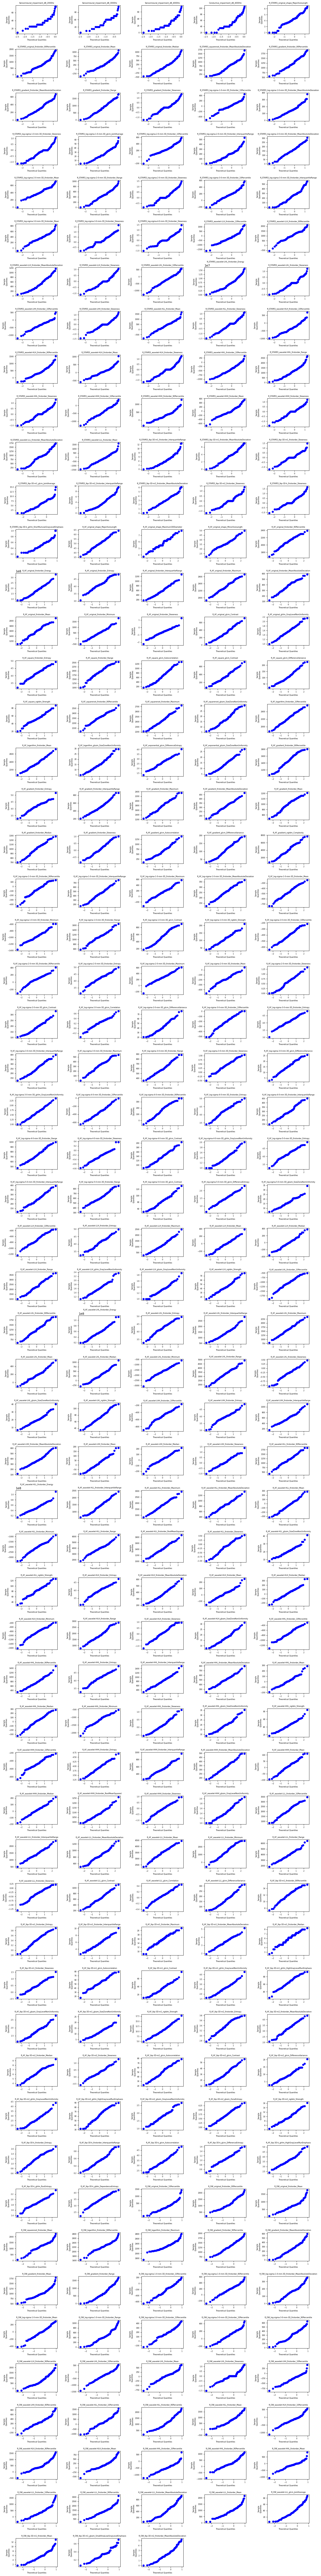

In [17]:
# Plotting qq plots of normal variables
qq_pplot_dir_ = 'Figures/'
qq_pplot_grid (df=df, vars=normal_vars, n_cols=5, figsize=(15,120), show=True, name= qq_pplot_dir_ + '3_1_1_norm_qq_plots_normal_vars.png')

In [18]:
# Plotting qq plots of non_normal variables
qq_pplot_dir_ = 'Figures/'
qq_pplot_grid (df=df, vars=non_normal_vars, n_cols=5, figsize=(15,500), show=False, name= qq_pplot_dir_ + '3_1_2_norm_qq_plots_non_normal_vars.pdf')

#### **4.2. Bivariate analysis**

* 4.2.1. **Quantitative** variables.
    * 4.2.1.1. **Otosclerosis vs No otosclerosis**.
        * 4.2.1.1.1. **Student T-tests** and **U-Mann-Whitney tests**.
        * 4.2.1.1.2. **Violin**, **box** and **hist** plots.
    * 4.2.1.2. **Otosclerosis_Contralateral_Healthy_Ear vs No otosclerosis**.
        * 4.2.1.2.1. **Student T-tests** and **U-Mann-Whitney tests**.
        * 4.2.1.2.2. **Violin**, **box** and **hist** plots.
* 4.2.2. **Qualitative** variables
    * 4.2.2.1. **Otosclerosis vs Non-otosclerosis**.
        * 4.2.2.1.1. **Chi-square tests with Monte Carlo simulated p-value.**
        * 4.2.2.1.2. **Bar** plots.
   * 4.2.2.2. **Otosclerosis_Contralateral_Healthy_Ear vs No otosclerosis**.
        * 4.2.2.2.1. **Chi-square tests with Monte Carlo simulated p-value.**
        * 4.2.2.2.2. **Bar** plots.

##### **4.2.1. Quantitative variables**

* 4.2.1.1. **Otosclerosis vs No otosclerosis**.
    * 4.2.1.1.1. **Student T-tests** and **U-Mann-Whitney tests**.
    * 4.2.1.1.2. **Violin**, **box** and **hist** plots.
* 4.2.1.2. **Otosclerosis_Contralateral_Healthy_Ear vs Non-otosclerosis**.
    * 4.2.1.2.1. **Student T-tests** and **U-Mann-Whitney tests**.
    * 4.2.1.2.2. **Violin**, **box** and **hist** plots.

###### **4.2.1.1. Otosclerosis vs Non-otosclerosis**

* 4.2.1.1.1. **Student T-tests** and **U-Mann-Whitney tests**.
* 4.2.1.1.2. **Violin**, **box** and **hist** plots.

In [19]:
# Descriptive Stats for Tests Tables
def compute_stats (df, vars_, normality):
    df_stats = df[vars_].describe()
    X_sd = [f'{mean:.2f} ± {std:.2f}' for mean, std in zip(df_stats.loc['mean'], df_stats.loc['std'])]
    
    if normality == True:
        stats = X_sd
        
    elif normality == False:
        df_stats.loc['iqr',] = df_stats.loc['75%'] - df_stats.loc['25%']
        M_iqr = [f'{median:.2f} ± {iqr:.2f}' for median, iqr in zip(df_stats.loc['50%'], df_stats.loc['iqr'])]
        stats = (X_sd, M_iqr)
    else:
        print('Set normality assumption')
        
    return stats

In [20]:
# Statistical test for quantitative variables

def biv_test (df, var, label, test):

  # Check that labels divide the dataset into two classes
  if len(df[label].unique()) != 2:
    print('Number of labels are different of two')

  elif len(df[label].unique()) == 2:
    g1, g2= list(df[label].unique())

    # Get the two distributions to compare
    group1 = df[df[label] == g1]
    group2 = df[df[label] == g2]

    # Compute Statistical Test
    if test == 'ttest':
      t_stat, p_val = ttest_ind(group1[var], group2[var],
                                equal_var=False,
                                nan_policy='omit',
                                alternative='two-sided',
                                keepdims=False)
      stat= t_stat

    elif test == 'mannwhitneyu':
      u_stat, p_val = mannwhitneyu(group1[var], group2[var],
                                   use_continuity=True,
                                   alternative='two-sided',
                                   axis=0, method='auto',
                                   nan_policy='omit',
                                   keepdims=False)
      stat= u_stat

    return (stat,p_val)

###### **4.2.1.1. Otosclerosis vs No otosclerosis**

In [21]:
# Compute the tests
biv_alpha= 0.05


# X±SD, M±IQR
X_sd_normal_vars    = compute_stats (df=df,                              vars_=normal_vars, normality=True)
X_sd_normal_vars_l0 = compute_stats (df=df[df['Label']=='Normal'],       vars_=normal_vars, normality=True)
X_sd_normal_vars_l1 = compute_stats (df=df[df['Label']=='Otosclerosis'], vars_=normal_vars, normality=True)

X_sd_non_normal_vars,    M_iqr_non_normal_vars    = compute_stats (df=df,                              vars_=non_normal_vars, normality=False)
X_sd_non_normal_vars_l0, M_iqr_non_normal_vars_l0 = compute_stats (df=df[df['Label']=='Normal'],       vars_=non_normal_vars, normality=False)
X_sd_non_normal_vars_l1, M_iqr_non_normal_vars_l1 = compute_stats (df=df[df['Label']=='Otosclerosis'], vars_=non_normal_vars, normality=False)


# t/u stats
tstat_normal_vars=     [biv_test (df, var, label='Label', test='ttest')[0]        for var in normal_vars]
ustat_non_normal_vars= [biv_test (df, var, label='Label', test='mannwhitneyu')[0] for var in non_normal_vars]

# p-values
pvals_normal_vars=     [biv_test (df, var, label='Label', test='ttest')[1]        for var in normal_vars]
pvals_non_normal_vars= [biv_test (df, var, label='Label', test='mannwhitneyu')[1] for var in non_normal_vars]

# Correct p-values following Benjamini-Hochberg FDR method
h0_reject_normal_vars,     fdr_pvals_normal_vars, _, _ =     multipletests(pvals_normal_vars,     alpha=biv_alpha, method='fdr_bh')
h0_reject_non_normal_vars, fdr_pvals_non_normal_vars, _, _ = multipletests(pvals_non_normal_vars, alpha=biv_alpha, method='fdr_bh')


# Build Dataframes with Statistical results
df_normal_vars= pd.DataFrame(data={'Normal Variables':      normal_vars,
                                   'X̄ ± SD':                X_sd_normal_vars,
                                   'X̄ ± SD Non-otos.':      X_sd_normal_vars_l0,
                                   'X̄ ± SD Otosclerosis':   X_sd_normal_vars_l1,
                                   'T-test t stat':         tstat_normal_vars,
                                   'T-test p-value':        pvals_normal_vars,
                                   'FDR corrected p-value': fdr_pvals_normal_vars})


df_non_normal_vars= pd.DataFrame(data={'Non_normal Variables':  non_normal_vars,
                                       'X̄ ± SD':                X_sd_non_normal_vars,
                                       'M ± IQR':               M_iqr_non_normal_vars,
                                       'X̄ ± SD Non-otos.':      X_sd_non_normal_vars_l0,
                                       'M ± IQR Non-otos.':     M_iqr_non_normal_vars_l0,
                                       'X̄ ± SD Otosclerosis':   X_sd_non_normal_vars_l1,
                                       'M ± IQR Otosclerosis':  M_iqr_non_normal_vars_l1,
                                       'UMW-test u stat':       ustat_non_normal_vars,
                                       'UMW-test p-value':      pvals_non_normal_vars,
                                       'FDR corrected p-value': fdr_pvals_non_normal_vars})


# Save Dataframes
tests_dir = 'Tables/'
df_save_tab(df_normal_vars,     tests_dir, '2_2_1_normal_vars_t_tests')
df_save_tab(df_non_normal_vars, tests_dir, '2_2_2_non_normal_vars_u_tests')


# Filter Statistical Significant test
sig_normal_vars =     df_normal_vars[h0_reject_normal_vars]
sig_non_normal_vars = df_non_normal_vars[h0_reject_non_normal_vars]

# Order by significance
sig_normal_vars =     sig_normal_vars.sort_values(by=['FDR corrected p-value'], ascending=True)
sig_non_normal_vars = sig_non_normal_vars.sort_values(by=['FDR corrected p-value'], ascending=True)

# Save Dataframes
tests_dir = 'Tables/'
df_save_tab(sig_normal_vars,     tests_dir, '2_2_1s_normal_vars_sig_t_tests')
df_save_tab(sig_non_normal_vars, tests_dir, '2_2_2s_non_normal_vars_sig_u_tests')


# Concatenate DataFrames
sig1= sig_normal_vars    [['Normal Variables', 'FDR corrected p-value']]
sig2= sig_non_normal_vars[['Non_normal Variables', 'FDR corrected p-value']]

sig1= sig1.rename(columns={'Normal Variables':'Variable'})
sig2= sig2.rename(columns={'Non_normal Variables':'Variable'})

sig_vars = pd.concat([sig1, sig2]).sort_values(by=['FDR corrected p-value'], ascending=True)

# Separate by segmentations
sig_vars_STAPE = sig_vars[sig_vars['Variable'].str.contains('STAPE')]
sig_vars_AF =    sig_vars[sig_vars['Variable'].str.contains('AF')]
sig_vars_OW =    sig_vars[sig_vars['Variable'].str.contains('OW')]


# Show results
print(f"Significant normal_vars t-tests:     {sig_normal_vars.shape[0]}")
print(f"Significant non_normal_vars u-tests: {sig_non_normal_vars.shape[0]}\n")
print(f"Significant features for STAPE segmentation: {sig_vars_STAPE.shape[0]}")
print(f"Significant features for AF segmentation:    {sig_vars_AF.shape[0]}")
print(f"Significant features for OW segmentation:    {sig_vars_OW.shape[0]}")

#print(f"Significant normal_vars t-tests:     {sig_normal_vars.shape[0]} - {list(sig_normal_vars['Normal Variables'].values)}\n")
#print(f"Significant non_normal_vars u-tests: {sig_non_normal_vars.shape[0]} - {list(sig_non_normal_vars['Non_normal Variables'].values)}\n")
#print(f"Significant features for STAPE segmentation: {sig_vars_STAPE.shape[0]} - {list(sig_vars_STAPE['Variable'])}\n")
#print(f"Significant features for AF segmentation:    {sig_vars_AF.shape[0]} - {list(sig_vars_AF['Variable'])}\n")
#print(f"Significant features for OW segmentation:    {sig_vars_OW.shape[0]} - {list(sig_vars_OW['Variable'])}\n")

Significant normal_vars t-tests:     37
Significant non_normal_vars u-tests: 30

Significant features for STAPE segmentation: 11
Significant features for AF segmentation:    56
Significant features for OW segmentation:    0


In [22]:
# Significant normal vars
sig_normal_vars

Normal Variables           X̄ ± SD  \
166                   R_AF_wavelet-LHH_firstorder_Mean     26.56 ± 59.98   
104           R_AF_log-sigma-1-0-mm-3D_firstorder_Mean  -476.73 ± 105.01   
95                     R_AF_gradient_firstorder_Median  1002.43 ± 129.67   
94                       R_AF_gradient_firstorder_Mean   993.82 ± 106.42   
136          R_AF_log-sigma-5-0-mm-3D_firstorder_Range   604.59 ± 103.70   
70                       R_AF_original_firstorder_Mean  1588.71 ± 210.71   
84              R_AF_logarithm_firstorder_10Percentile  2220.44 ± 150.23   
212                   R_AF_wavelet-LLL_firstorder_Mean  3486.05 ± 432.43   
67         R_AF_original_firstorder_InterquartileRange   604.07 ± 220.58   
89               R_AF_gradient_firstorder_90Percentile  1459.86 ± 187.04   
72                   R_AF_original_firstorder_Skewness      -0.66 ± 0.51   
223    R_AF_lbp-3D-m1_firstorder_MeanAbsoluteDeviation       3.42 ± 0.59   
227                       R_AF_lbp-3D-m1_glcm_Contrast     35.91 ± 12.68   
135  R_AF_log-sigma-5-0-mm-3D_firstorder_Interquart...    242.73 ± 58.88   
130          R_AF_log-sigma-4-0-mm-3D_firstorder_Range   732.45 ± 112.57   
128        R_AF_log-sigma-4-0-mm-3D_firstorder_Entropy       4.26 ± 0.34   
4              R_STAPES_original_shape_MajorAxisLength       4.23 ± 0.99   
209           R_AF_wavelet-LLL_firstorder_10Percentile  2109.69 ± 565.24   
110   R_AF_log-sigma-2-0-mm-3D_firstorder_90Percentile    75.14 ± 121.04   
219             R_AF_lbp-3D-m1_firstorder_90Percentile      11.92 ± 1.74   
105        R_AF_log-sigma-1-0-mm-3D_firstorder_Minimum  -971.57 ± 140.61   
221       R_AF_lbp-3D-m1_firstorder_InterquartileRange       5.76 ± 1.48   
113           R_AF_log-sigma-2-0-mm-3D_firstorder_Mean   -189.46 ± 92.00   
129  R_AF_log-sigma-4-0-mm-3D_firstorder_Interquart...    293.84 ± 65.76   
69      R_AF_original_firstorder_MeanAbsoluteDeviation    377.68 ± 95.67   
147      R_AF_wavelet-LLH_glszm_GrayLevelNonUniformity       1.32 ± 0.17   
222                  R_AF_lbp-3D-m1_firstorder_Maximum      15.67 ± 2.47   
85                      R_AF_logarithm_firstorder_Mean  2365.15 ± 131.32   
24   R_STAPES_log-sigma-3-0-mm-3D_firstorder_Interq...   247.74 ± 137.09   
19   R_STAPES_log-sigma-2-0-mm-3D_firstorder_MeanAb...    161.52 ± 67.93   
21       R_STAPES_log-sigma-2-0-mm-3D_firstorder_Range   476.36 ± 217.66   
217                  R_AF_wavelet-LLL_glcm_Correlation       0.06 ± 0.17   
77                    R_AF_square_glcm_Autocorrelation   668.92 ± 275.91   
226                R_AF_lbp-3D-m1_glcm_Autocorrelation     52.37 ± 12.13   
229      R_AF_lbp-3D-m1_glrlm_HighGrayLevelRunEmphasis     64.03 ± 14.31   
18   R_STAPES_log-sigma-2-0-mm-3D_firstorder_Interq...   204.62 ± 110.55   
81             R_AF_squareroot_firstorder_90Percentile   2311.03 ± 97.35   

     X̄ ± SD Non-otos. X̄ ± SD Otosclerosis  T-test t stat  T-test p-value  \
166      54.06 ± 57.64        -2.67 ± 47.69      -5.347677        0.000001   
104    -520.45 ± 95.66      -430.27 ± 94.77       4.710476        0.000008   
95    1054.04 ± 114.66      947.60 ± 122.95      -4.447648        0.000023   
94     1037.02 ± 83.86      947.92 ± 109.34      -4.529597        0.000018   
136     564.45 ± 90.82      647.25 ± 100.21       4.299166        0.000042   
70    1670.18 ± 196.39     1502.14 ± 191.54      -4.309304        0.000039   
84    2279.52 ± 132.99     2157.66 ± 142.93      -4.384497        0.000030   
212   3647.99 ± 371.85     3313.98 ± 429.08      -4.128005        0.000080   
67     521.59 ± 198.12      691.70 ± 210.89       4.130263        0.000078   
89    1530.19 ± 159.84     1385.13 ± 186.26      -4.146585        0.000075   
72        -0.85 ± 0.44         -0.46 ± 0.51       4.060135        0.000102   
223        3.21 ± 0.54          3.65 ± 0.55       3.983186        0.000132   
227      31.38 ± 10.87        40.73 ± 12.79       3.909438        0.000176   
135     222.35 ± 56.35       264.39 ± 54.04       3.78961

In [23]:
# Significant non-normal vars
sig_non_normal_vars

Non_normal Variables  \
466           R_AF_exponential_gldm_DependenceVariance   
460  R_AF_exponential_glrlm_LongRunLowGrayLevelEmph...   
572        R_AF_wavelet-LHH_firstorder_RootMeanSquared   
647              R_AF_lbp-3D-m1_glcm_ClusterProminence   
483         R_AF_log-sigma-1-0-mm-3D_firstorder_Energy   
462           R_AF_exponential_glszm_LargeAreaEmphasis   
541  R_AF_log-sigma-5-0-mm-3D_glszm_LargeAreaHighGr...   
415                  R_AF_original_firstorder_Kurtosis   
526          R_AF_log-sigma-4-0-mm-3D_glcm_Correlation   
654                    R_AF_lbp-3D-m1_ngtdm_Complexity   
459      R_AF_exponential_glrlm_GrayLevelNonUniformity   
524    R_AF_log-sigma-4-0-mm-3D_glcm_ClusterProminence   
533          R_AF_log-sigma-4-0-mm-3D_ngtdm_Complexity   
464              R_AF_exponential_glszm_ZonePercentage   
14           R_STAPES_original_shape_Maximum3DDiameter   
414              R_AF_original_firstorder_10Percentile   
151      R_STAPES_log-sigma-3-0-mm-3D_firstorder_Range   
131  R_STAPES_log-sigma-2-0-mm-3D_firstorder_90Perc...   
148  R_STAPES_log-sigma-3-0-mm-3D_firstorder_90Perc...   
429                    R_AF_square_firstorder_Skewness   
150  R_STAPES_log-sigma-3-0-mm-3D_firstorder_MeanAb...   
453           R_AF_exponential_firstorder_10Percentile   
441                R_AF_squareroot_firstorder_Kurtosis   
431                      R_AF_square_glcm_ClusterShade   
499      R_AF_log-sigma-2-0-mm-3D_glcm_Autocorrelation   
525         R_AF_log-sigma-4-0-mm-3D_glcm_ClusterShade   
593                    R_AF_wavelet-HLL_ngtdm_Contrast   
92        R_STAPES_exponential_glszm_LargeAreaEmphasis   
652                   R_AF_lbp-3D-m1_glszm_ZoneEntropy   
679              R_AF_lbp-3D-k_glszm_GrayLevelVariance   

                     X̄ ± SD                  M ± IQR  \
466              1.29 ± 2.52              0.44 ± 1.03   
460              0.26 ± 0.18              0.21 ± 0.23   
572          1124.78 ± 79.11          1113.52 ± 92.55   
647        2833.87 ± 2101.69        2251.73 ± 2530.32   
483  9959101.77 ± 4623689.72  9214831.37 ± 6051494.87   
462              3.33 ± 4.20              1.91 ± 1.87   
541         1229.52 ± 642.08         1101.54 ± 660.95   
415              3.03 ± 1.15              2.73 ± 1.29   
526              0.49 ± 0.14              0.51 ± 0.17   
654          281.68 ± 123.34          270.92 ± 182.05   
459              2.51 ± 1.31              2.12 ± 1.57   
524    477055.91 ± 390665.34    358769.32 ± 390528.37   
533         1913.20 ± 605.22         1905.41 ± 768.56   
464              0.77 ± 0.14              0.80 ± 0.20   
14               3.52 ± 0.68              3.32 ± 0.96   
414          960.48 ± 339.93          887.80 ± 473.80   
151          535.87 ± 243.03          576.67 ± 303.64   
131          615.69 ± 155.07          643.25 ± 219.10   
148          594.36 ± 229.01          619.63 ± 304.03   
429             -0.06 ± 0.52             -0.14 ± 0.73   
150           186.30 ± 83.28          206.05 ± 114.38   
453            35.40 ± 49.06            13.95 ± 30.39   
441              4.37 ± 2.65              3.38 ± 2.75   
431        -433.59 ± 2814.07        -503.92 ± 2327.48   
499          349.37 ± 167.28          320.74 ± 189.90   
525       -3848.06 ± 3593.32       -2601.63 ± 4046.46   
593            42.47 ± 40.60            29.64 ± 36.03   
92               1.20 ± 0.40              1.00 ± 0.00   
652              3.72 ± 0.33              3.78 ± 0.41   
679              0.74 ± 0.36              0.69 ± 0.16   

           X̄ ± SD Non-otos.        M ± IQR Non-otos.  \
466              0.47 ± 0.58              0.25 ± 0.36   
460              0.18 ± 0.12              0.17 ± 0.15   
572          1158.00 ± 80.56          1155.97 ± 82.61   
647        2042.78 ± 1541.94        1655.52 ± 1719.29   
483  8193772.74 ± 3661914.82  7571286.98 ± 4305311.62   
462              2.05 ± 1.15              1.56 ± 0.90   
541          985.44 ± 374.32          908.06 ± 512.44   
415        

In [24]:
# Print Significant Radiomic Features by Class
def rad_feats_seg (df_vars, seg):

    print(f'\n{seg}\n-------------')
    _first_order_ = [var for var in df_vars['Variable'] if '_firstorder_' in var]
    _shape_ =       [var for var in df_vars['Variable'] if '_shape_' in var]
    _textures_ =    [var for var in df_vars['Variable'] if not any(exclude in var for exclude in ['_firstorder_', '_shape_'])]
    _rad_feats =    [_first_order_, _shape_, _textures_]

    for idx, rad_feat in enumerate(['_firstorder_', '_shape_', '_textures_']):
        print(f'{rad_feat}\n')
        for var in _rad_feats [idx]:
            print(var)
        print('')


# STAPES
rad_feats_seg (sig_vars_STAPE, seg='STAPES')

# ANTEFENESTRAL
rad_feats_seg (sig_vars_AF, seg='AF')

# OVAL WINDOW
rad_feats_seg (sig_vars_OW, seg='OW')


STAPES
-------------
_firstorder_

R_STAPES_log-sigma-3-0-mm-3D_firstorder_InterquartileRange
R_STAPES_log-sigma-3-0-mm-3D_firstorder_Range
R_STAPES_log-sigma-2-0-mm-3D_firstorder_90Percentile
R_STAPES_log-sigma-2-0-mm-3D_firstorder_MeanAbsoluteDeviation
R_STAPES_log-sigma-2-0-mm-3D_firstorder_Range
R_STAPES_log-sigma-3-0-mm-3D_firstorder_90Percentile
R_STAPES_log-sigma-2-0-mm-3D_firstorder_InterquartileRange
R_STAPES_log-sigma-3-0-mm-3D_firstorder_MeanAbsoluteDeviation

_shape_

R_STAPES_original_shape_MajorAxisLength
R_STAPES_original_shape_Maximum3DDiameter

_textures_

R_STAPES_exponential_glszm_LargeAreaEmphasis


AF
-------------
_firstorder_

R_AF_wavelet-LHH_firstorder_Mean
R_AF_log-sigma-1-0-mm-3D_firstorder_Mean
R_AF_gradient_firstorder_Median
R_AF_gradient_firstorder_Mean
R_AF_log-sigma-5-0-mm-3D_firstorder_Range
R_AF_original_firstorder_Mean
R_AF_logarithm_firstorder_10Percentile
R_AF_wavelet-LLL_firstorder_Mean
R_AF_original_firstorder_InterquartileRange
R_AF_gradient_fir

In [25]:
# Plotting Significant variables

def quantitative_plotting (df, plotting_vars, hue, kind, ncols, figsize, title, show, name=None):

    # Set up plot grid
    num_vars = len(plotting_vars)
    n_cols = ncols
    n_rows = int(np.ceil(num_vars / n_cols))

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=False, sharey=False)
    fig.suptitle(title, fontsize=30, y=1.01)
    axes = axes.flatten()

    # Create subplots
    for i, var in enumerate(plotting_vars):

      if kind == 'violin':
        sns.violinplot(data=df, x=hue, y=var, ax=axes[i], inner='quartile')

      elif kind == 'box':
        sns.boxplot(data=df, x=hue, y=var, ax=axes[i], color='#77DD77')

      elif kind == 'hist':
        sns.histplot(data=df, x=var, hue=hue, bins=20, kde=True, ax=axes[i])

      axes[i].set_title(var)
      axes[i].set_xlabel('')
      axes[i].set_ylabel('')

    # Remove empty sublpots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ajust spaces
    plt.tight_layout()

    # Plot subplots
    if show == True:
      plt.show()

    # Save plot
    if name != None:
      fig.savefig(name + '.png', bbox_inches='tight', format='png', dpi=300)
      fig.savefig(name + '.pdf', bbox_inches='tight', format='pdf', dpi=300)

    # Close plot
    plt.close()

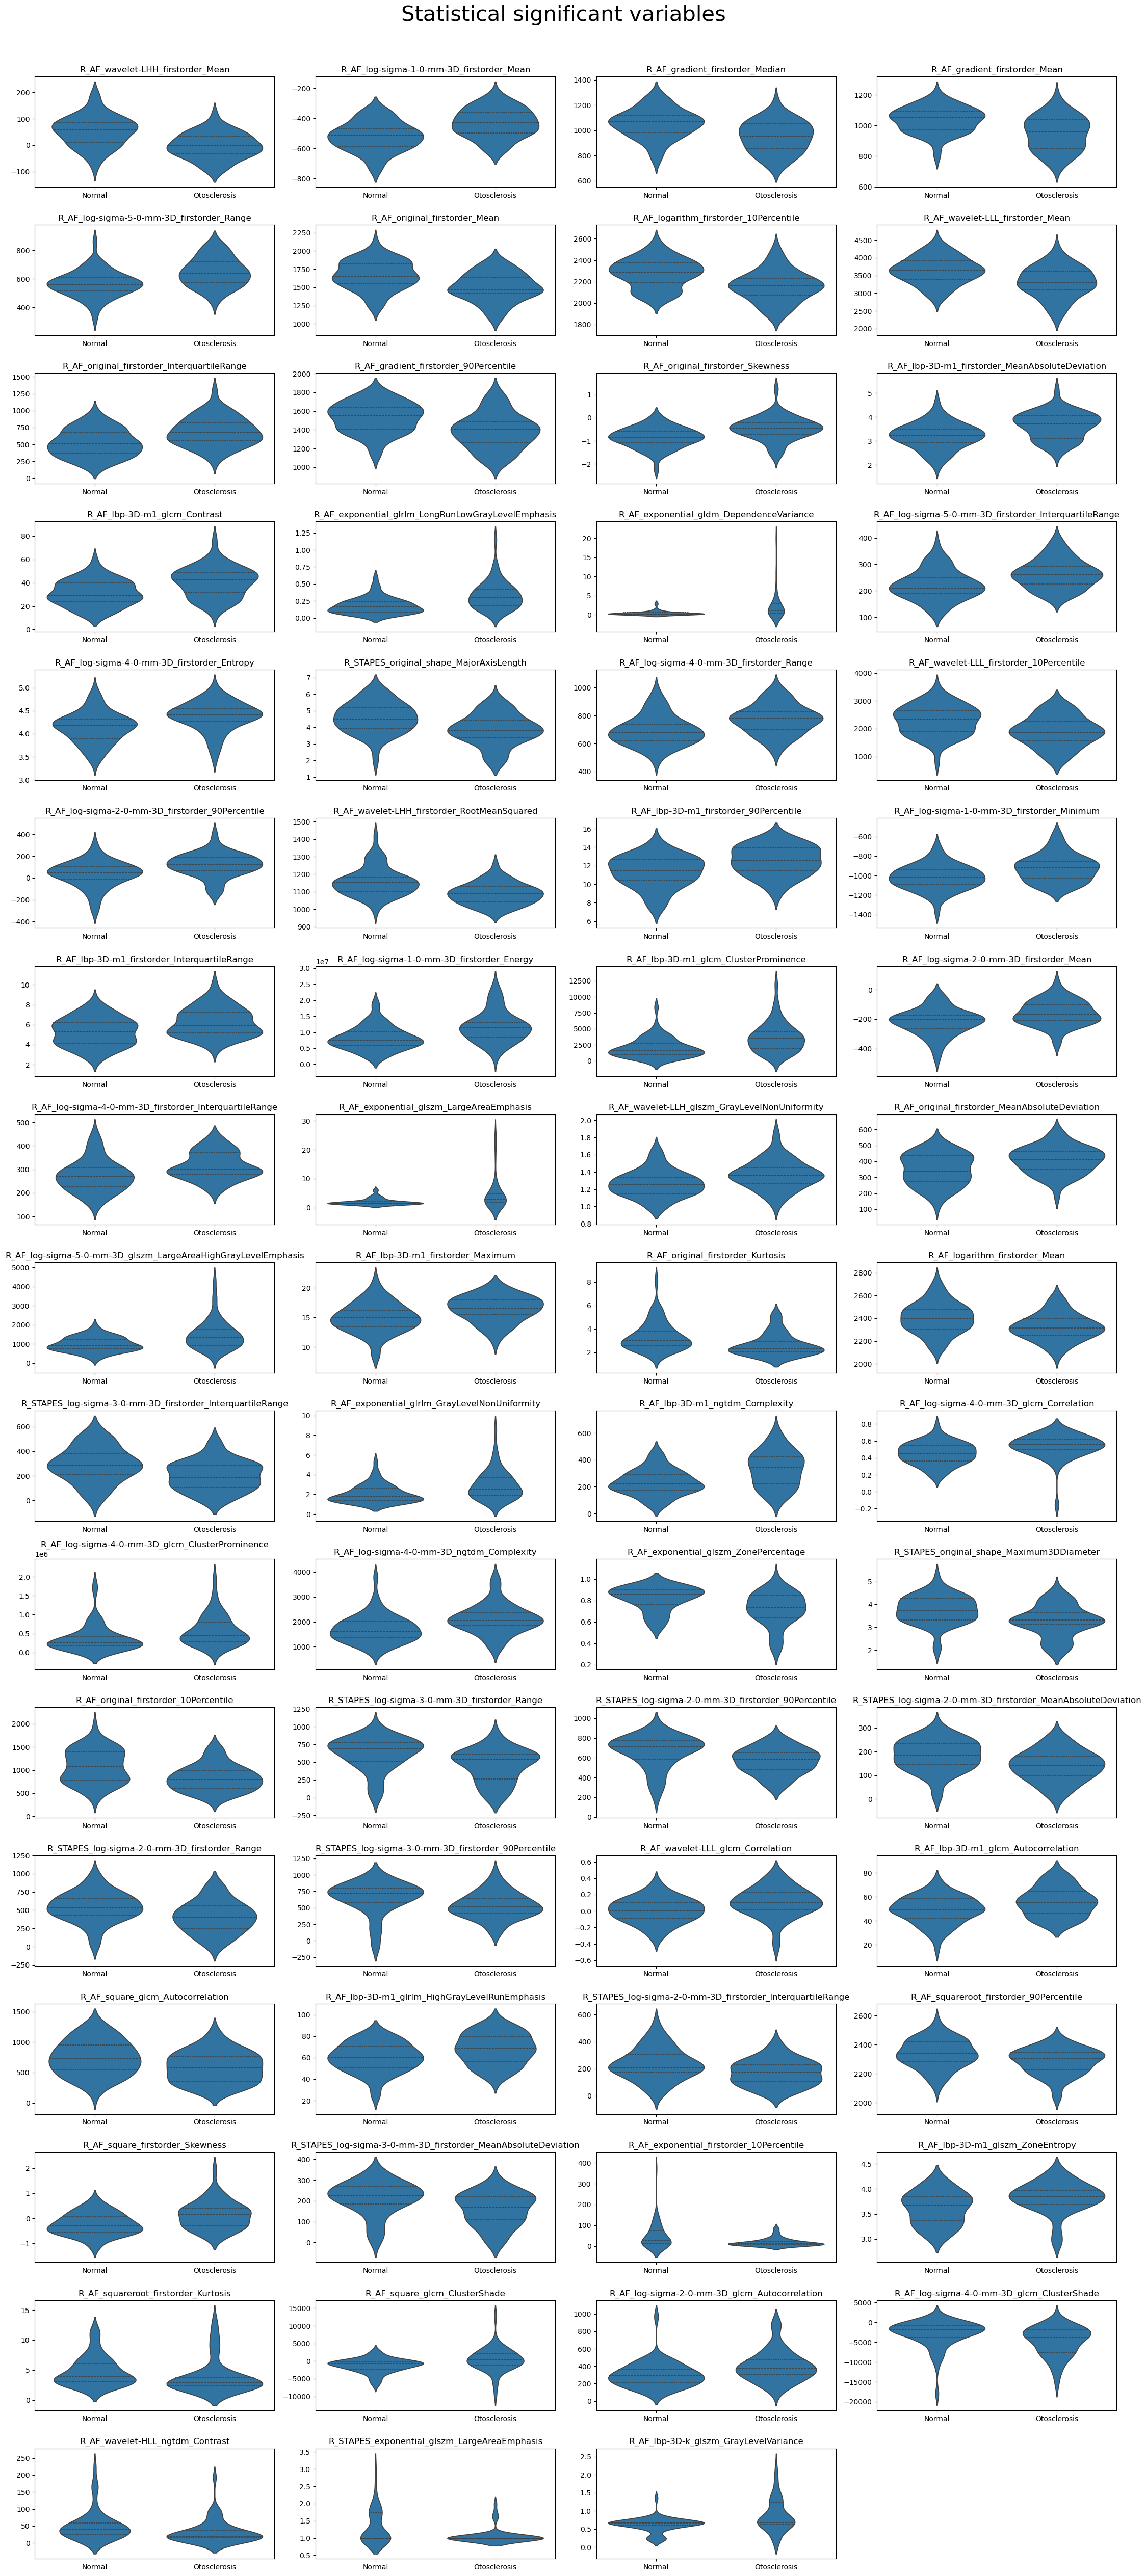

In [26]:
# Plotting Significant variables - Violin Plots
save_fig = 'Figures/3_2_1_violin_plots_sig_vars'
quantitative_plotting (df=df, plotting_vars=sig_vars['Variable'].values.tolist(), hue='Label', kind='violin', ncols=4, figsize=(22,50),
                       title='Statistical significant variables', show=True, name=save_fig)

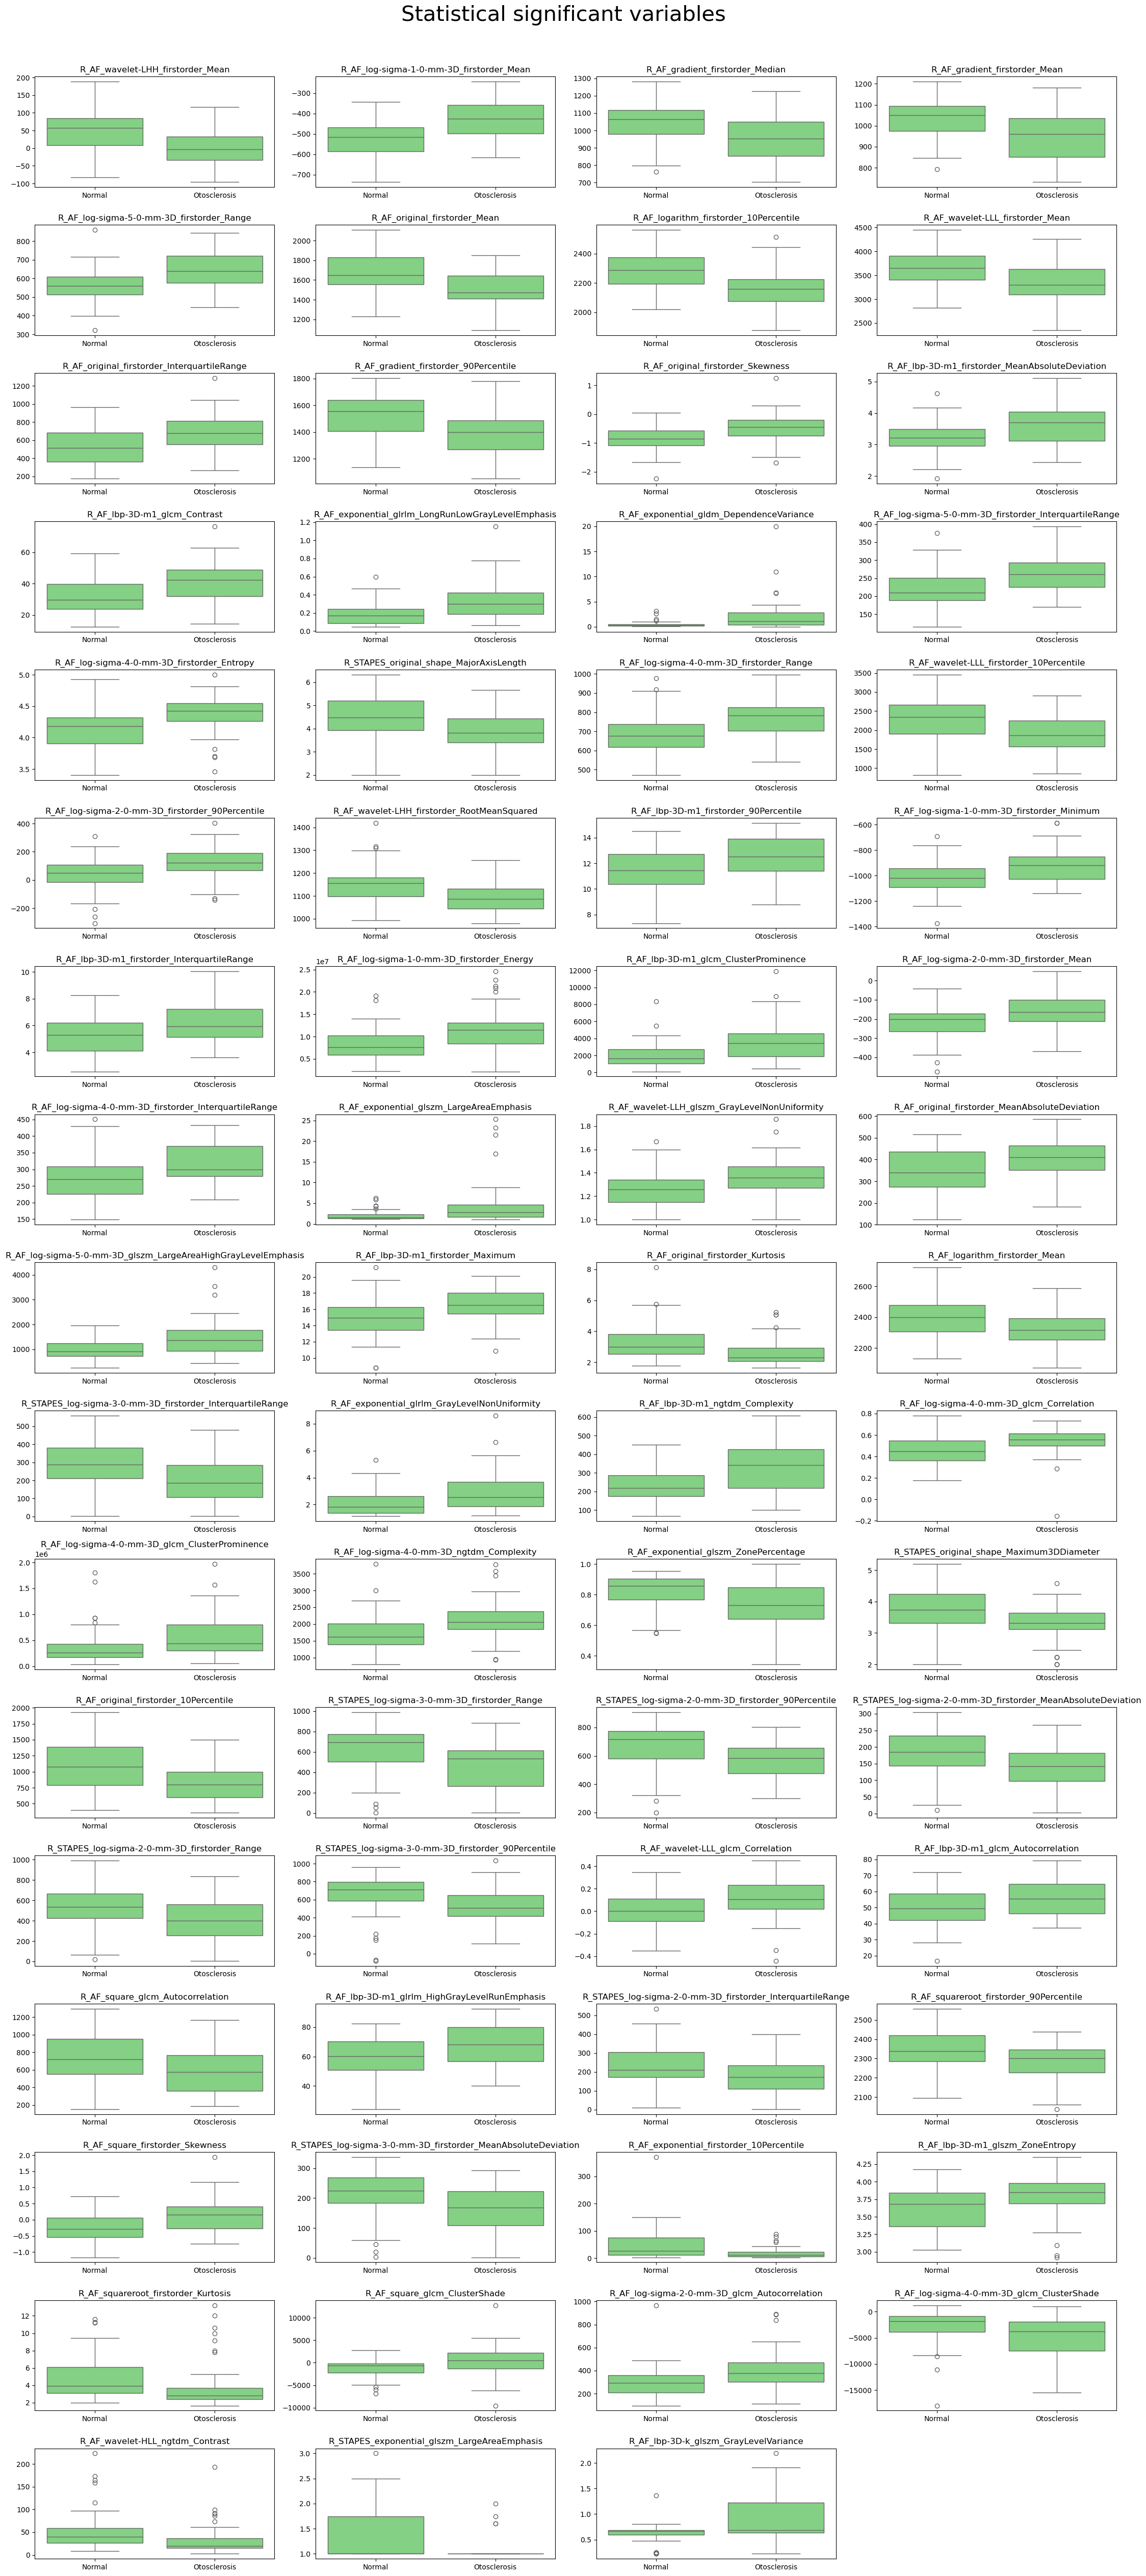

In [27]:
# Plotting Significant variables - Box plots
save_fig = 'Figures/3_2_2_box_plots_sig_vars'
quantitative_plotting (df=df, plotting_vars=sig_vars['Variable'].values.tolist(), hue='Label', kind='box', ncols=4, figsize=(22,50),
                       title='Statistical significant variables', show=True, name=save_fig)

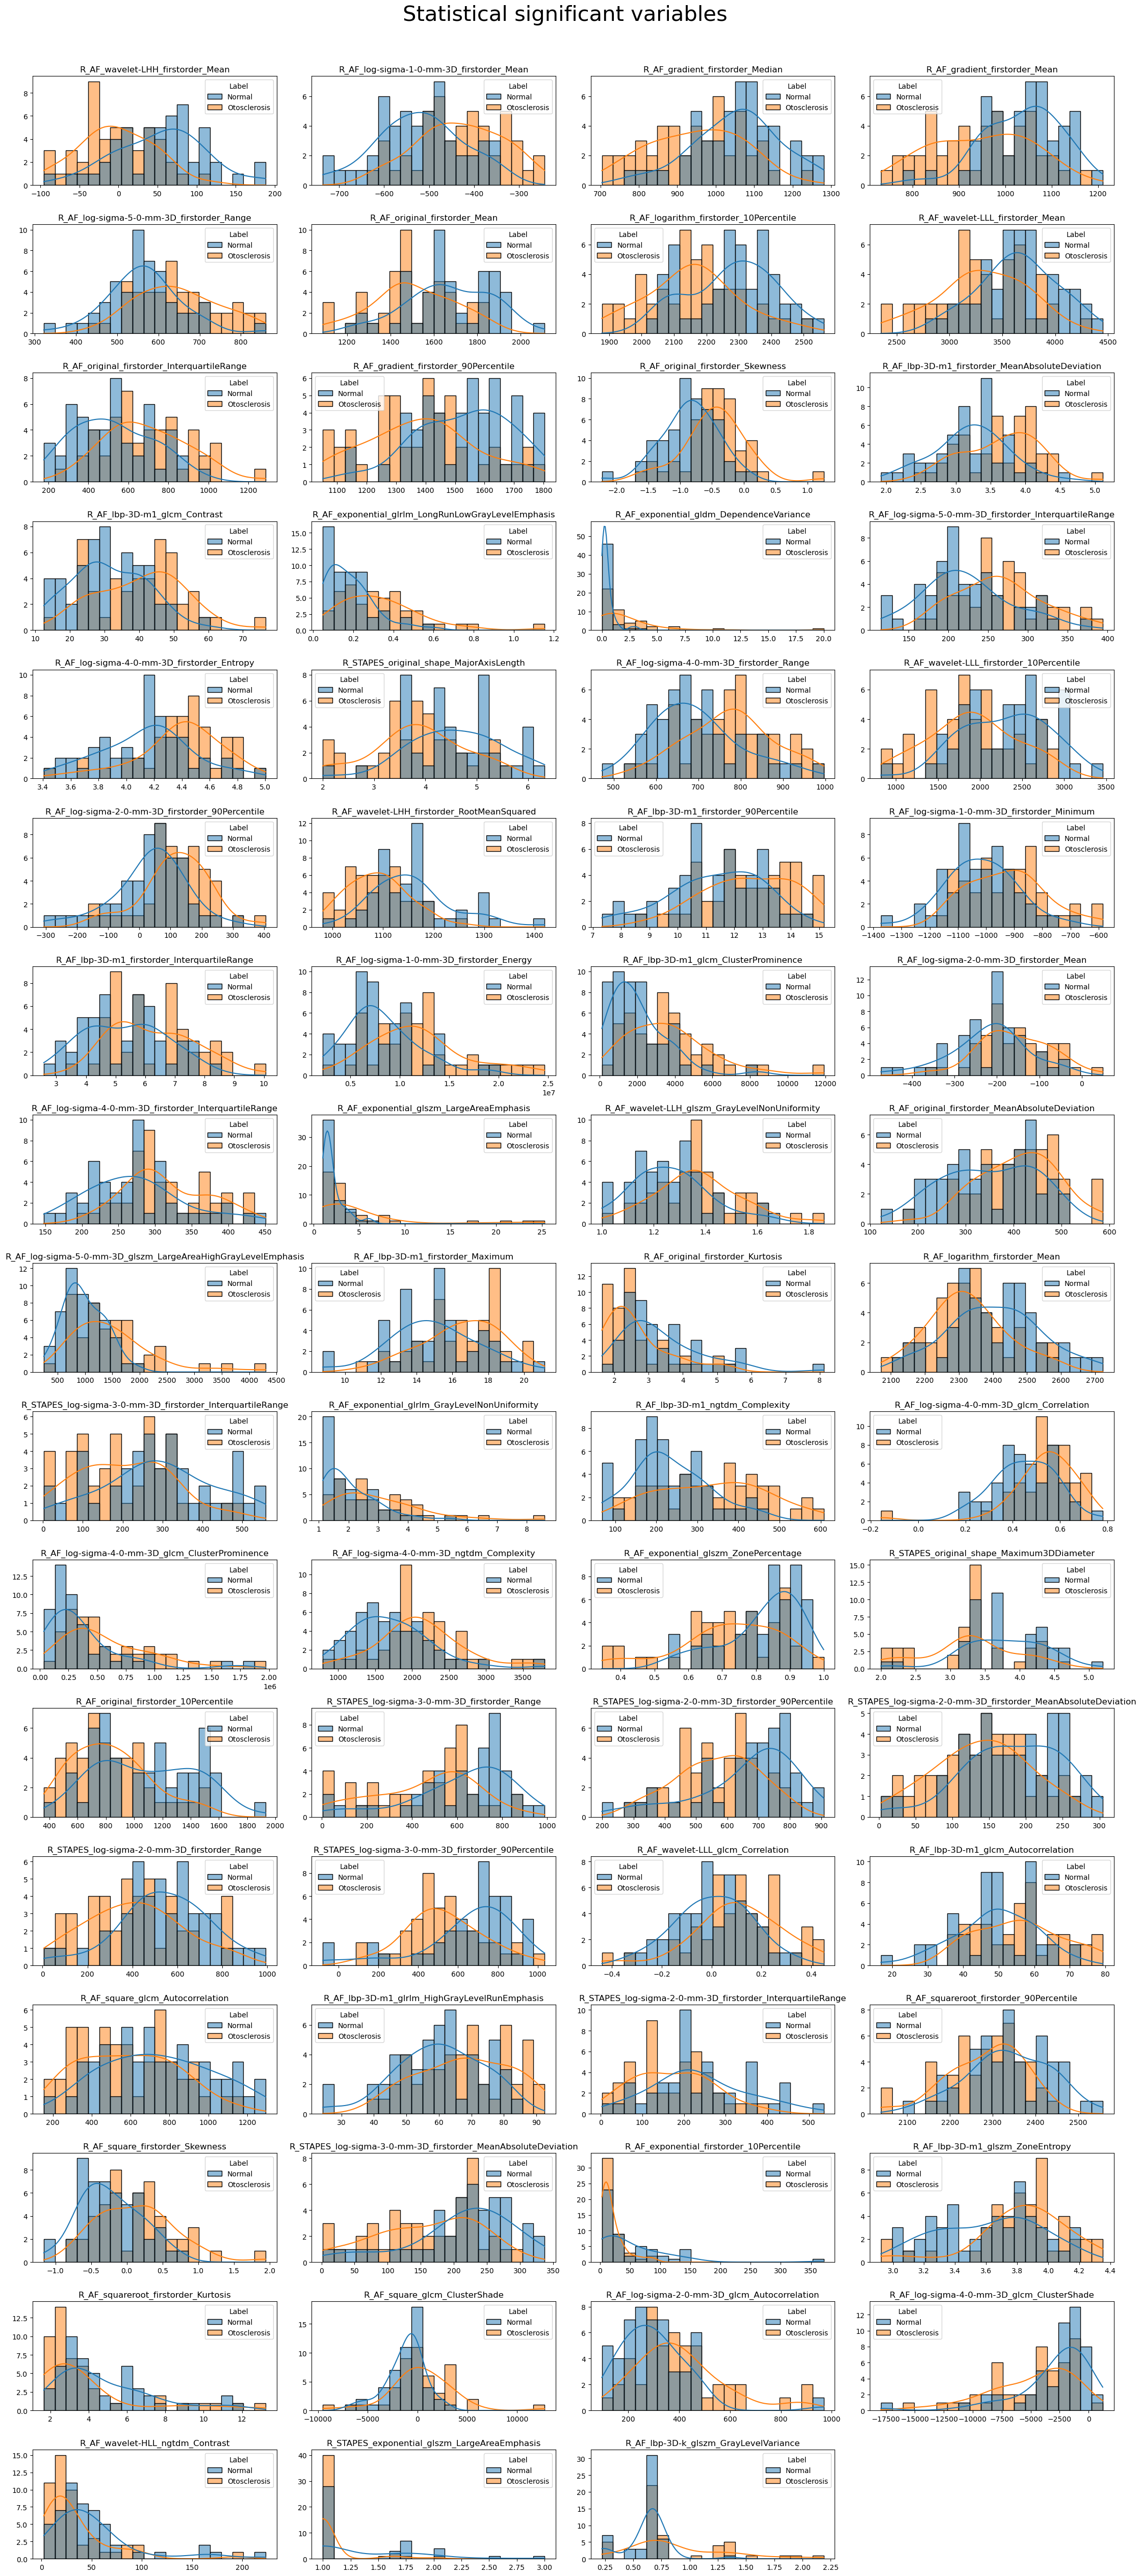

In [28]:
# Plotting Significant variables - Hist plots
save_fig = 'Figures/3_2_3_hist_plots_sig_vars'
quantitative_plotting (df=df, plotting_vars=sig_vars['Variable'].values.tolist(), hue='Label', kind='hist', ncols=4, figsize=(22,50),
                       title='Statistical significant variables', show=True, name=save_fig)

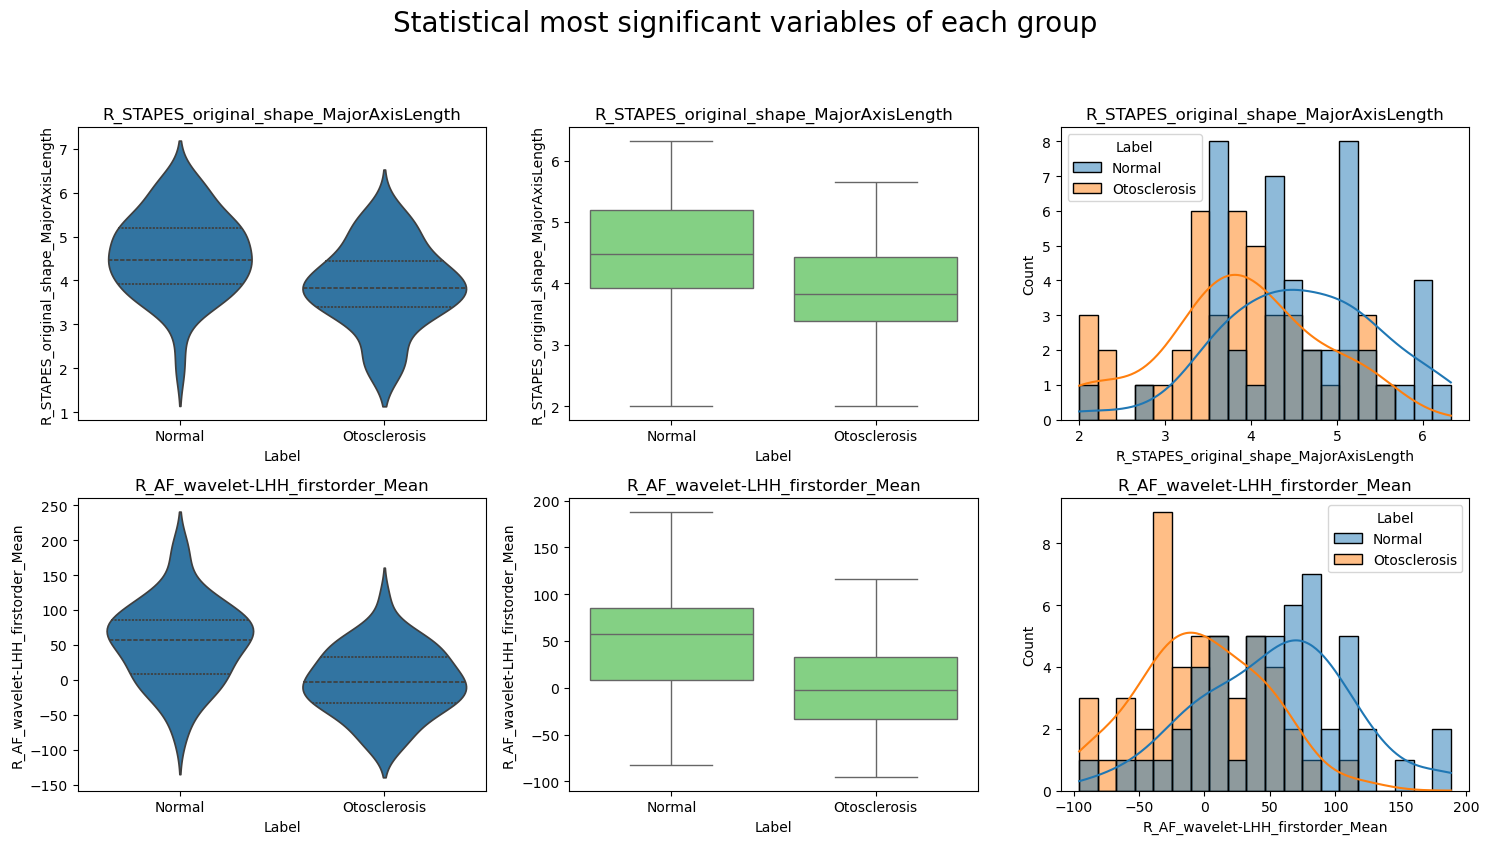

In [29]:
# Plotting the top most significant features for each segmentation
sig1= sig_normal_vars[['Normal Variables', 'FDR corrected p-value']]
sig2= sig_non_normal_vars[['Non_normal Variables', 'FDR corrected p-value']]

sig1= sig1.rename(columns={'Normal Variables':'Variable'})
sig2= sig2.rename(columns={'Non_normal Variables':'Variable'})

sig_vars_= pd.concat([sig1, sig2]).sort_values(by=['FDR corrected p-value'], ascending=True)

# Select most significant features
top_STAPE= [var for var in sig_vars_['Variable'] if 'STAPE' in var][0]
top_AF=    [var for var in sig_vars_['Variable'] if 'AF' in var][0]

# Create figure
fig_most_sig, axs = plt.subplots(2, 3, figsize=(15, 8))
fig_most_sig.suptitle('Statistical most significant variables of each group', fontsize=20, y=1.05)

# Create subplots for STAPE
sns.violinplot(data=df, x='Label',   y=top_STAPE, ax=axs[0,0], inner='quartile')
sns.boxplot(   data=df, x='Label',   y=top_STAPE, ax=axs[0,1], color='#77DD77')
sns.histplot(  data=df, x=top_STAPE, hue='Label', ax=axs[0,2], bins=20, kde=True)

axs[0, 0].set_title(top_STAPE)
axs[0, 1].set_title(top_STAPE)
axs[0, 2].set_title(top_STAPE)
#sns.move_legend(axs[0, 2], 'upper left')

# Create subplots for AF
sns.violinplot(data=df,  x='Label', y=top_AF,    ax=axs[1,0], inner='quartile')
sns.boxplot(   data=df,  x='Label', y=top_AF,    ax=axs[1,1], color='#77DD77')
sns.histplot(  data=df,  x=top_AF,  hue='Label', ax=axs[1,2], bins=20, kde=True)

axs[1, 0].set_title(top_AF)
axs[1, 1].set_title(top_AF)
axs[1, 2].set_title(top_AF)
#sns.move_legend(axs[1, 2], 'upper left')

# Ajustar el diseño
plt.tight_layout()

# Mostrar la figura
plt.show()

# Save plot
fig_most_sig.savefig('Figures/3_2_4_plots_most_sig_vars.png', bbox_inches='tight', dpi=400)
fig_most_sig.savefig('Figures/3_2_4_plots_most_sig_vars.pdf', bbox_inches='tight', dpi=400)

###### **4.2.1.2. Otosclerosis_Contralateral_Healthy_Ear vs No otosclerosis**

* 4.2.1.2.1. **Student T-tests** and **U-Mann-Whitney tests**.
* 4.2.1.2.2. **Violin**, **box** and **hist** plots.

In [30]:
# Check label counts
df['Label_extended'].value_counts()

Label_extended
Otosclerosis                                  41
Normal                                        34
Normal_ContraOS                               14
NoTC_Otosclerosis                              7
Falta de desarrollo del ligamento platinar     1
Malformación estribo                           1
Necrosis de rama larga del yunque              1
Name: count, dtype: int64

In [31]:
# Create a label which separates Non-Otosclerosis (Normal) in Normal and Normal but with otosclerosis in the contralateral ear
df.loc[df['Label_extended'] == 'Normal',          'Label_ContrEar'] = 0
df.loc[df['Label_extended'] == 'Normal_ContraOS', 'Label_ContrEar'] = 1

df_subset_ContraEar_ = df.dropna(subset=['Label_ContrEar'], axis=0)
df_subset_ContraEar=   df_subset_ContraEar_.dropna(how='all', axis=1)
df.drop(columns=['Label_ContrEar'])

col_with_all_nan   = df_subset_ContraEar_.loc[:, df_subset_ContraEar_.isna().all()]
normal_vars_CE     = list(set(normal_vars) - set(col_with_all_nan))
non_normal_vars_CE = list(set(non_normal_vars) - set(col_with_all_nan))

df_subset_ContraEar.shape

(48, 1327)

In [32]:
# Compute the tests for contralateral ear
biv_alpha= 0.05


# X±SD, M±IQR
X_sd_normal_vars_subset_ContraEar    = compute_stats (df=df_subset_ContraEar,                                            vars_=normal_vars_CE, normality=True)
X_sd_normal_vars_subset_ContraEar_l0 = compute_stats (df=df_subset_ContraEar[df_subset_ContraEar['Label_ContrEar']== 0], vars_=normal_vars_CE, normality=True)
X_sd_normal_vars_subset_ContraEar_l1 = compute_stats (df=df_subset_ContraEar[df_subset_ContraEar['Label_ContrEar']== 1], vars_=normal_vars_CE, normality=True)

X_sd_non_normal_vars_subset_ContraEar,    M_iqr_non_normal_vars_subset_ContraEar    = compute_stats (df=df_subset_ContraEar,                                            vars_=non_normal_vars_CE, normality=False)
X_sd_non_normal_vars_subset_ContraEar_l0, M_iqr_non_normal_vars_subset_ContraEar_l0 = compute_stats (df=df_subset_ContraEar[df_subset_ContraEar['Label_ContrEar']== 0], vars_=non_normal_vars_CE, normality=False)
X_sd_non_normal_vars_subset_ContraEar_l1, M_iqr_non_normal_vars_subset_ContraEar_l1 = compute_stats (df=df_subset_ContraEar[df_subset_ContraEar['Label_ContrEar']== 1], vars_=non_normal_vars_CE, normality=False)


# t/u stats
tstat_normal_vars_contr_ear =     [biv_test (df_subset_ContraEar, var, label='Label_ContrEar', test='ttest')[0]        for var in normal_vars_CE]
ustat_non_normal_vars_contr_ear = [biv_test (df_subset_ContraEar, var, label='Label_ContrEar', test='mannwhitneyu')[0] for var in non_normal_vars_CE]

# p-values
pvals_normal_vars_contr_ear =     [biv_test (df_subset_ContraEar, var, label='Label_ContrEar', test='ttest')[1]        for var in normal_vars_CE]
pvals_non_normal_vars_contr_ear = [biv_test (df_subset_ContraEar, var, label='Label_ContrEar', test='mannwhitneyu')[1] for var in non_normal_vars_CE]

# Correct p-values following Benjamini-Hochberg FDR method
h0_reject_normal_vars_contr_ear,     fdr_pvals_normal_vars_contr_ear, _, _ =     multipletests(pvals_normal_vars_contr_ear,     alpha=biv_alpha, method='fdr_bh')
h0_reject_non_normal_vars_contr_ear, fdr_pvals_non_normal_vars_contr_ear, _, _ = multipletests(pvals_non_normal_vars_contr_ear, alpha=biv_alpha, method='fdr_bh')

# Build Dataframes with Statistical results
df_normal_vars_contr_ear = pd.DataFrame(data={'Normal Variables':      normal_vars_CE,
                                              'X̄ ± SD':                X_sd_normal_vars_subset_ContraEar,
                                              'X̄ ± SD Non-otos.':      X_sd_normal_vars_subset_ContraEar_l0,
                                              'X̄ ± SD OtosContrEar':   X_sd_normal_vars_subset_ContraEar_l1,
                                              'T-test t stat':         tstat_normal_vars_contr_ear,
                                              'T-test p-value':        pvals_normal_vars_contr_ear,
                                              'FDR corrected p-value': fdr_pvals_normal_vars_contr_ear})


df_non_normal_vars_contr_ear = pd.DataFrame(data={'Non_normal Variables':  non_normal_vars_CE,
                                                  'X̄ ± SD':                X_sd_non_normal_vars_subset_ContraEar,
                                                  'M ± IQR':               M_iqr_non_normal_vars_subset_ContraEar,
                                                  'X̄ ± SD Non-otos.':      X_sd_non_normal_vars_subset_ContraEar_l0,
                                                  'M ± IQR Non-otos.':     M_iqr_non_normal_vars_subset_ContraEar_l0,
                                                  'X̄ ± SD OtosContrEar':   X_sd_non_normal_vars_subset_ContraEar_l1,
                                                  'M ± IQR OtosContrEar':  M_iqr_non_normal_vars_subset_ContraEar_l1,
                                                  'UMW-test u stat':       ustat_non_normal_vars_contr_ear,
                                                  'UMW-test p-value':      pvals_non_normal_vars_contr_ear,
                                                  'FDR corrected p-value': fdr_pvals_non_normal_vars_contr_ear})
    

# Save Dataframes
tests_dir = 'Tables/'
df_save_tab(df_normal_vars_contr_ear,     tests_dir, '2_3_1_normal_vars_contr_ear_t_tests')
df_save_tab(df_non_normal_vars_contr_ear, tests_dir, '2_3_2_non_normal_vars_contr_ear_u_tests')


# Filter Statistical Significant test
sig_normal_vars_contr_ear =     df_normal_vars_contr_ear[h0_reject_normal_vars_contr_ear]
sig_non_normal_vars_contr_ear = df_non_normal_vars_contr_ear[h0_reject_non_normal_vars_contr_ear]

# Order by significance
sig_normal_vars_contr_ear  =     sig_normal_vars_contr_ear.sort_values(by=['FDR corrected p-value'], ascending=True)
sig_non_normal_vars_contr_ear  = sig_non_normal_vars_contr_ear.sort_values(by=['FDR corrected p-value'], ascending=True)

# Save Dataframes
tests_dir = 'Tables/'
df_save_tab(sig_normal_vars_contr_ear,     tests_dir, '2_3_1s_normal_vars_contr_ear_sig_t_tests')
df_save_tab(sig_non_normal_vars_contr_ear, tests_dir, '2_3_2s_non_normal_vars_contr_ear_sig_u_tests')


# Concatenate DataFrames
sig1_contr_ear = sig_normal_vars_contr_ear    [['Normal Variables', 'FDR corrected p-value']]
sig2_contr_ear = sig_non_normal_vars_contr_ear[['Non_normal Variables', 'FDR corrected p-value']]

sig1_contr_ear = sig1_contr_ear.rename(columns={'Normal Variables':'Variable'})
sig2_contr_ear = sig2_contr_ear.rename(columns={'Non_normal Variables':'Variable'})

sig_vars_contr_ear = pd.concat([sig1_contr_ear, sig2_contr_ear]).sort_values(by=['FDR corrected p-value'], ascending=True)

# Separate by segmentations
sig_vars_STAPE_contr_ear = sig_vars_contr_ear[sig_vars_contr_ear['Variable'].str.contains('STAPE')]
sig_vars_AF_contr_ear =    sig_vars_contr_ear[sig_vars_contr_ear['Variable'].str.contains('AF')]
sig_vars_OW_contr_ear =    sig_vars_contr_ear[sig_vars_contr_ear['Variable'].str.contains('OW')]

# Show results
print('Contralateral Ear')
print(f"Significant normal_vars_contr_ear t-tests:                     {sig_normal_vars_contr_ear.shape[0]}")
print(f"Significant non_normal_vars_contr_ear u-tests:                 {sig_non_normal_vars_contr_ear.shape[0]}\n")
print(f"Significant features for STAPE segmentation contralateral ear: {sig_vars_STAPE_contr_ear.shape[0]}")
print(f"Significant features for AF segmentation contralateral ear:    {sig_vars_AF_contr_ear.shape[0]}")
print(f"Significant features for OW segmentation contralateral ear:    {sig_vars_OW_contr_ear.shape[0]}")

#print(f"Significant normal_vars_contr_ear t-tests:                     {sig_normal_vars_contr_ear.shape[0]} - {list(sig_normal_vars_contr_ear['Normal Variables'].values)}\n")
#print(f"Significant non_normal_vars_contr_ear u-tests:                 {sig_non_normal_vars_contr_ear.shape[0]} - {list(sig_non_normal_vars_contr_ear['Non_normal Variables'].values)}\n")
#print(f"Significant features for STAPE segmentation contralateral ear: {sig_vars_STAPE_contr_ear.shape[0]} - {list(sig_vars_STAPE_contr_ear['Variable'])}\n")
#print(f"Significant features for AF segmentation contralateral ear:    {sig_vars_AF_contr_ear.shape[0]} - {list(sig_vars_AF_contr_ear['Variable'])}\n")
#print(f"Significant features for OW segmentation contralateral ear:    {sig_vars_OW_contr_ear.shape[0]} - {list(sig_vars_OW_contr_ear['Variable'])}\n")

Contralateral Ear
Significant normal_vars_contr_ear t-tests:                     0
Significant non_normal_vars_contr_ear u-tests:                 0

Significant features for STAPE segmentation contralateral ear: 0
Significant features for AF segmentation contralateral ear:    0
Significant features for OW segmentation contralateral ear:    0


In [33]:
# Explore results
df_normal_vars_contr_ear[df_normal_vars_contr_ear ['FDR corrected p-value'] < 0.06]

Normal Variables         X̄ ± SD  \
20               R_AF_wavelet-LLL_firstorder_Skewness    -0.39 ± 0.30   
49  R_AF_log-sigma-1-0-mm-3D_firstorder_MeanAbsolu...  258.00 ± 47.31   

   X̄ ± SD Non-otos. X̄ ± SD OtosContrEar  T-test t stat  T-test p-value  \
20      -0.48 ± 0.30         -0.17 ± 0.20       4.168145        0.000193   
49    243.36 ± 43.53       293.56 ± 36.88       4.059969        0.000349   

    FDR corrected p-value  
20               0.050366  
49               0.050366

In [34]:
df_non_normal_vars_contr_ear[df_non_normal_vars_contr_ear ['FDR corrected p-value'] < 0.06]

Empty DataFrame
Columns: [Non_normal Variables, X̄ ± SD, M ± IQR, X̄ ± SD Non-otos., M ± IQR Non-otos., X̄ ± SD OtosContrEar, M ± IQR OtosContrEar, UMW-test u stat, UMW-test p-value, FDR corrected p-value]
Index: []

##### **4.2.2. Qualitative variables**

* 4.2.2.1. **Otosclerosis vs No otosclerosis**.
  * 4.2.2.1.1. **Chi-square tests with Monte Carlo simulated p-value.**
  * 4.2.2.1.2. **Bar** plots.
* 4.2.2.2. **Otosclerosis_Contralateral_Healthy_Ear vs No otosclerosis**.
  * 4.2.2.2.1. **Chi-square tests with Monte Carlo simulated p-value.**
  * 4.2.2.2.2. **Bar** plots.

In [35]:
# Chi-square test with Monte-Carlo permutation p-values (H0: independence)

def chi2_test(df, x, y, alpha=0.05, print_=True, n_perm=10000):
    cross_tab = pd.crosstab(df[x], df[y])

    # Remove empty rows or columns
    cross_tab = cross_tab.loc[(cross_tab.sum(axis=1) > 0),(cross_tab.sum(axis=0) > 0)]

    # Observed chi-square statistic (no Yates correction)
    chi2_stat, _, dof, _ = chi2_contingency(cross_tab, correction=False)

    # Monte-Carlo permutation under H0 (independence)
    chi2_perm = []
    y_vals = df[y].values.copy()

    for _ in range(n_perm):
        np.random.shuffle(y_vals)
        perm_tab = pd.crosstab(df[x], y_vals)

        # Align permuted table with observed table structure
        perm_tab = perm_tab.reindex(
            index=cross_tab.index,
            columns=cross_tab.columns,
            fill_value=0
        )

        chi2_i, _, _, _ = chi2_contingency(perm_tab, correction=False)
        chi2_perm.append(chi2_i)

    chi2_perm = np.array(chi2_perm)

    # Monte-Carlo p-value
    simulated_pval = np.mean(chi2_perm >= chi2_stat)

    # Significance decision
    result = 'Significant' if simulated_pval < alpha else 'Non-significant'

    if print_:
        display(cross_tab)
        print(f'Chi-square statistic: {chi2_stat:.4f}')
        print(f'Monte-Carlo p-value: {simulated_pval:.4f}')
        print(f'Result: {result}\n')

    return chi2_stat, simulated_pval, result

In [36]:
# Plotting Significant Categorical Variables

def categories_plotting (df, plotting_vars, hue, ncols, figsize, title, show, name=None):

    df2 = df.copy()
    
    # Set up plot grid
    num_vars = len(plotting_vars)
    n_cols = ncols
    n_rows = int(np.ceil(num_vars / n_cols))

    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, sharex=False, sharey=False)
    fig.suptitle(title, fontsize=30, y=1.01, horizontalalignment='center')
    axes = axes.flatten()

    # Create subplots
    for i, var in enumerate(plotting_vars):

        sns.countplot(data=df2, x=var, hue=hue, ax=axes[i])
        
        axes[i].set_title(var)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('')
        axes[i].tick_params(axis='x', rotation=16, labelsize=8)

    # Remove empty sublpots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Ajust spaces
    plt.tight_layout()

    # Plot subplots
    if show == True:
      plt.show()

    # Save plot
    if name != None:
      fig.savefig(name + '.png', bbox_inches='tight', format='png', dpi=300)
      fig.savefig(name + '.pdf', bbox_inches='tight', format='pdf', dpi=300)

    # Close plot
    plt.close()

###### **4.2.2.1. Otosclerosis vs No otosclerosis**

* 4.2.2.1.1. **Chi-square tests with Monte Carlo simulated p-value.**
* 4.2.2.1.2. **Bar** plots.

In [37]:
cat_names = {
    'Sex': ['Male', 'Female'],
    'Pathological_Ear': ['Right ear', 'Left ear'],
    'Hearing_impairment_Pathological_Ear': ['(20-40 dB)', '(40-70 dB)', '(<20 dB)', '(> 90 dB)', '(70-90 dB)'],
    'Carhart_notch': ['Absence', '<15dB', '>15dB'],
    'Temporal_Bone_CT_scan_Findings_Pathological_Ear': ['Retro. + fenestral', 'Fenestral', 'No findings'],
    'Surgical_Treatment': ['Stapedotomy', 'Stap. malformation', 'Miring + prosthesis', 'Tympanoplasty'],
    'Post_surgical_Vertigo': ['No', 'Yes'],
    'One_Week_Post_surgical_Tonal_Audiometry_Pathological_Ear': ['Conductive HL', 'Mixed HL', 'Sensorial HL', 'Normal hearing'],
    'Hearing_impairment_One_Week_Post_surgical': ['(20-40 dB)', '(40-70 dB)', '(<20 dB)', '(70-90 dB)'],
    'One_Month_Post_surgical_Tonal_Audiometry_Pathological_Ear': ['Conductive HL', 'Mixed HL', 'Sensorial HL', 'No hearing loss'],
    'Hearing_impairment_One_Month_Post_surgical': ['(20-40 dB)', '(40-70 dB)', '(<20 dB)', '(70-90 dB)'],
    'Otosclerosis_Contralateral_Ear': ['No', 'Med_history + & CT +/-', 'Med_history + & CT +',  'Surg. + and CT +', 'Surg. + and CT -', 'Med_history - & CT +', 'Med_history + & CT -'],
    'Label': ['Normal', 'Otosclerosis'],
    'Label_extended': ['Platinal lig. underdevelopment', 'Stap. malformation', 'Incus long process necrosis', 'Otosclerosis + & CT -', 'Normal', 'Normal & Otos. contr. ear', 'Otosclerosis']
}


for column, new_values in cat_names.items():
    df[column] = df[column].cat.remove_unused_categories()
    values = df[column].cat.categories.to_list()
    mapping = dict(zip(values, new_values[:len(values)]))
    df[column] = df[column].map(mapping)
    
# Check result
df.head()

EPI_CODE     Sex Pathological_Ear Hearing_impairment_Pathological_Ear  \
0  EPI_0001    Male         Left ear                          (40-70 dB)   
1  EPI_0002  Female         Left ear                          (40-70 dB)   
2  EPI_0003  Female        Right ear                          (40-70 dB)   
3  EPI_0004    Male        Right ear                          (40-70 dB)   
4  EPI_0005    Male         Left ear                          (40-70 dB)   

   Sensorineural_impairment_dB_250Hz  Sensorineural_impairment_dB_500Hz  \
0                          25.000000                          35.000000   
1                           0.000000                          10.000000   
2                          35.000000                          35.000000   
3                           0.000000                           5.000000   
4                           0.000000                          15.000000   

   Sensorineural_impairment_dB_1000Hz  Sensorineural_impairment_dB_2000Hz  \
0                           35.000000                           45.000000   
1                           20.000000                           30.000000   
2                           25.000000                           60.000000   
3                           20.000000                           30.000000   
4                           30.000000                           40.000000   

   Sensorineural_impairment_dB_3000Hz  Sensorineural_impairment_dB_4000Hz  \
0                           35.000000                           15.000000   
1                           10.000000                            5.000000   
2                           55.000000                           50.000000   
3                           20.000000                           20.000000   
4                           25.000000                           35.000000   

  Carhart_notch  Conductive_impairment_dB_250Hz  \
0         <15dB                       70.000000   
1         >15dB                       60.000000   
2         <15dB                       75.000000   
3         <15dB                       45.000000   
4         <15dB                       45.000000   

   Conductive_impairment_dB_500Hz  Conductive_impairment_dB_1000Hz  \
0                       70.000000                        65.000000   
1                       55.000000                        60.000000   
2                       70.000000                        55.000000   
3                       50.000000                        50.000000   
4                       45.000000                        45.000000   

   Conductive_impairment_dB_2000Hz  Conductive_impairment_dB_3000Hz  \
0                        50.000000                        45.000000   
1                        40.000000                        40.000000   
2                        70.000000                        80.000000   
3                        45.000000                        50.000000   
4                        40.000000                        50.000000   

   Conductive_impairment_dB_4000Hz  \
0                        45.000000   
1                        45.000000   
2                        75.000000   
3                        55.000000   
4                        55.000000   

  Temporal_Bone_CT_scan_Findings_Pathological_Ear Surgical_Treatment  \
0                                     No findings        Stapedotomy   
1                                       Fenestral        Stapedotomy   
2                                       Fenestral        Stapedotomy   
3                                       Fenestral        Stapedotomy   
4                                       Fenestral        Stapedotomy   

  Post_surgical_Vertigo  \
0                    No   
1                    No   
2                    No   
3                    No   
4                    No   

  One_Week_Post_surgical_Tonal_Audiometry_Pathological_Ear  \
0                                           Mixed HL         
1                                           Mixed HL         
2  

In [38]:
# Calculate p-values (one inferential row per variable; category rows are descriptive only)
cat_values = []

value_counts = []
value_counts_l0 = []
value_counts_l1 = []

freq_values = []
freq_values_l0 = []
freq_values_l1 = []

chi2_stats = []
chi2_pvals = []
results = []

for cat in categories:
    if 'Label' not in cat:

        # Compute Chi2 test with MonteCarlo permutation p-value
        chi2_stat, chi2_pval, result = chi2_test(df=df, x=cat, y='Label', alpha=0.05, print_=False)

        # Define a stable category order (overall counts)
        levels = df[cat].value_counts().index.tolist()

        # Counts overall (all subjects)
        vc_all = df[cat].value_counts().reindex(levels, fill_value=0)
        total_count = int(vc_all.sum())

        # Counts by group (aligned to same levels, missing -> 0)
        vc_l0 = df.loc[df['Label'] == 'Normal', cat].value_counts().reindex(levels, fill_value=0)
        vc_l1 = df.loc[df['Label'] == 'Otosclerosis', cat].value_counts().reindex(levels, fill_value=0)

        total_count_l0 = int(vc_l0.sum())
        total_count_l1 = int(vc_l1.sum())


        # Variable row (inferential)
        cat_values.append(cat)

        value_counts.append(total_count)
        value_counts_l0.append(total_count_l0)
        value_counts_l1.append(total_count_l1)

        # Overall percent is 100 for the variable-row (same aesthetics as you had)
        freq_values.append(100.0)
        freq_values_l0.append(100.0)
        freq_values_l1.append(100.0)

        chi2_stats.append(chi2_stat)
        chi2_pvals.append(chi2_pval)
        results.append(result)

        # Category rows (descriptive)
        for lvl in levels:
            cat_values.append('     ' + str(lvl))

            n_all = int(vc_all.loc[lvl])
            n_l0 = int(vc_l0.loc[lvl])
            n_l1 = int(vc_l1.loc[lvl])

            value_counts.append(n_all)
            value_counts_l0.append(n_l0)
            value_counts_l1.append(n_l1)

            # Percentages within each group (standard Table 1 convention)
            freq_values.append(round(n_all * 100 / total_count, 2) if total_count > 0 else np.nan)
            freq_values_l0.append(round(n_l0 * 100 / total_count_l0, 2) if total_count_l0 > 0 else np.nan)
            freq_values_l1.append(round(n_l1 * 100 / total_count_l1, 2) if total_count_l1 > 0 else np.nan)

            # IMPORTANT: no inferential stats on category rows
            chi2_stats.append(np.nan)
            chi2_pvals.append(np.nan)
            results.append('')

# Build DataFrame with the results (same look, but statistically correct)
pd.options.display.float_format = '{:.2f}'.format
df_chi2_tests = pd.DataFrame(data={
                                    'Variable': cat_values,
                                    'n': value_counts,
                                    '%': freq_values,
                                    'n (Non-otos)': value_counts_l0,
                                    '%(Non-otos)': freq_values_l0,
                                    'n(Otosclerosis)': value_counts_l1,
                                    '%(Otosclerosis)': freq_values_l1,
                                    'Chi2 stat': chi2_stats,
                                    'Chi2 p-value': chi2_pvals,
                                    'result': results
                                })

# Filter significant tests: ONLY variable rows have p-values, so this is safe
df_sig_chi2_tests = df_chi2_tests[
    (df_chi2_tests['Chi2 p-value'].notna()) &
    (df_chi2_tests['result'] == 'Significant')
]

# Save Dataframe
tests_dir = 'Tables/'
df_save_tab(df_chi2_tests,     tests_dir, '2_2_3_chi_square_tests')
df_save_tab(df_sig_chi2_tests, tests_dir, '2_2_3s_sig_chi_square_tests')

# Show significant results
df_sig_chi2_tests

Variable   n      %  \
0                                                 Sex  99 100.00   
16    Temporal_Bone_CT_scan_Findings_Pathological_Ear  99 100.00   
20                                 Surgical_Treatment  51 100.00   
27  One_Week_Post_surgical_Tonal_Audiometry_Pathol...  33 100.00   

    n (Non-otos)  %(Non-otos)  n(Otosclerosis)  %(Otosclerosis)  Chi2 stat  \
0             51       100.00               48           100.00       4.37   
16            51       100.00               48           100.00      74.36   
20             3       100.00               48           100.00      33.31   
27             1       100.00               32           100.00      33.00   

    Chi2 p-value       result  
0           0.04  Significant  
16          0.00  Significant  
20          0.00  Significant  
27          0.00  Significant

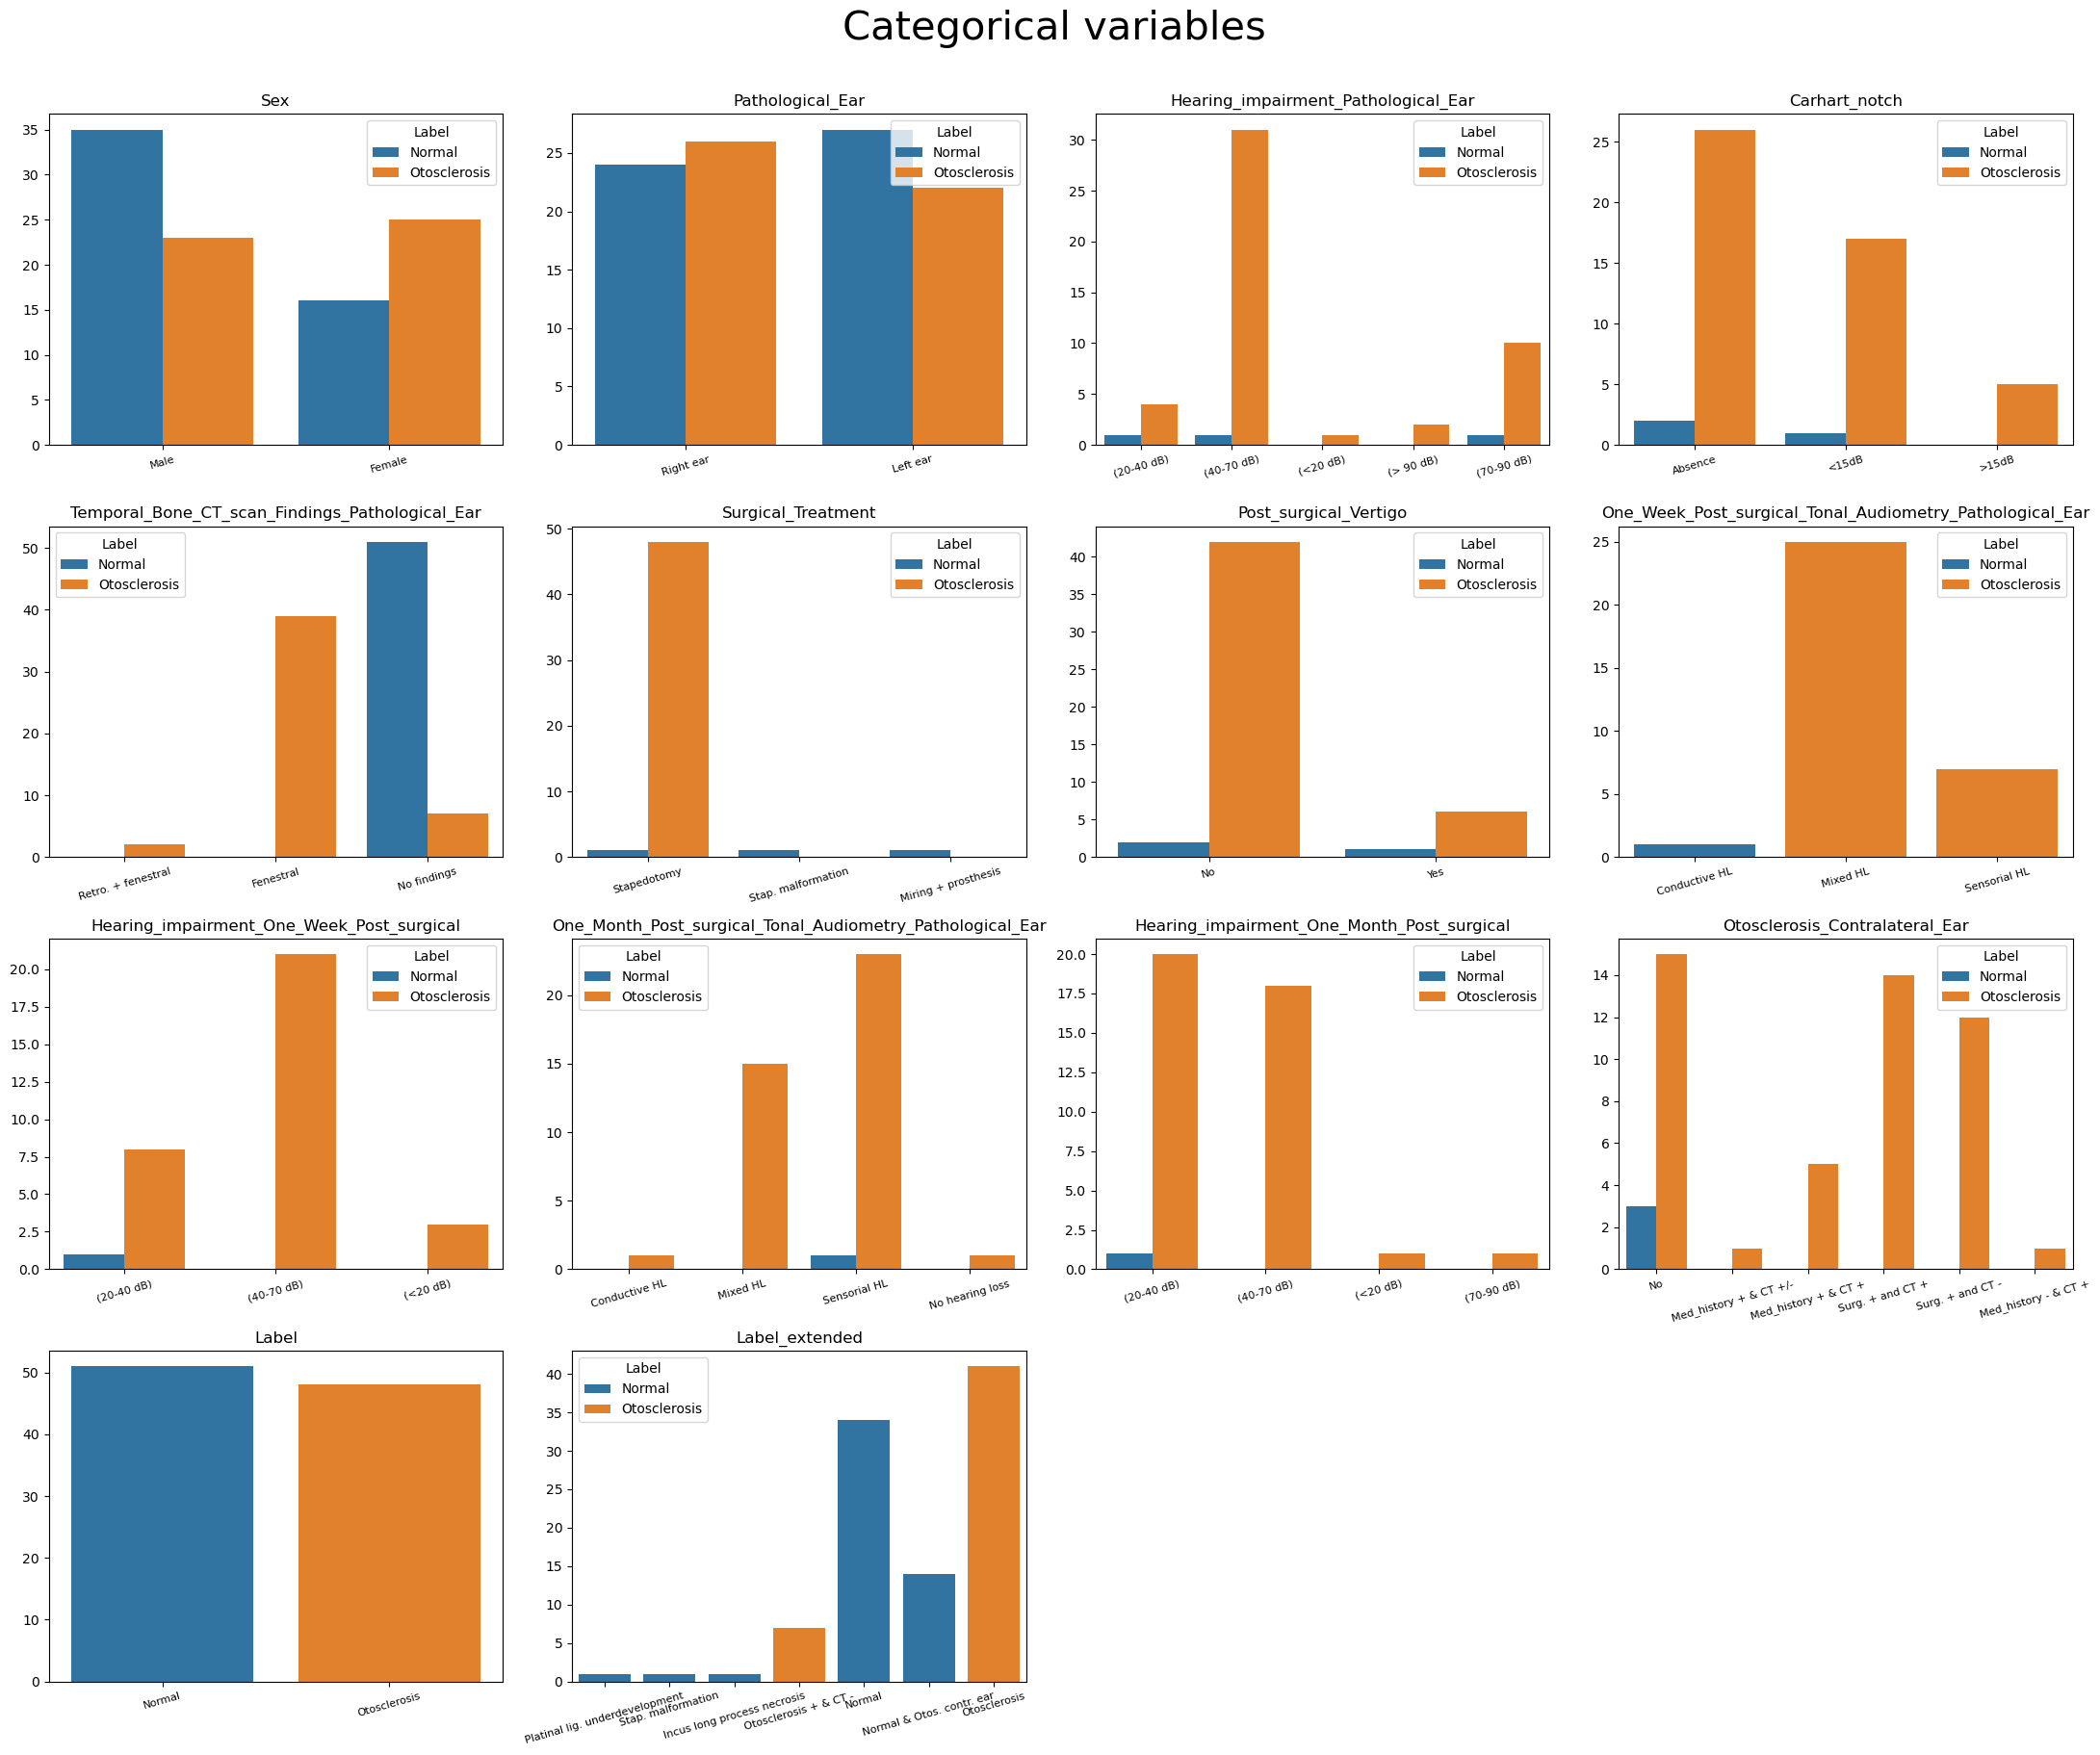

In [39]:
# Plotting Categorical variables - Bar plots
save_fig = 'Figures/3_2_5_bar_plots_categorical_vars'
categories_plotting (df=df, plotting_vars=list(categories), hue='Label', ncols=4, figsize=(22,18),
                     title='Categorical variables',         show=True,   name=save_fig)

###### **4.2.2.2. Otosclerosis_Contralateral_Healthy_Ear vs No otosclerosis**

* 4.2.2.2.1. **Chi-square tests with Monte Carlo simulated p-value.**
* 4.2.2.2.2. **Bar** plots.

In [40]:
for column, new_values in cat_names.items():
    if column in df_subset_ContraEar.columns:
        df_subset_ContraEar[column] = (df_subset_ContraEar[column].cat.remove_unused_categories())
        values = df_subset_ContraEar[column].cat.categories.to_list()
        mapping = dict(zip(values, new_values[:len(values)]))
        df_subset_ContraEar[column] = df_subset_ContraEar[column].map(mapping)

# Check result
df_subset_ContraEar.head()

EPI_CODE     Sex Pathological_Ear  \
70  EPI_0071    Male        Right ear   
71  EPI_0072  Female        Right ear   
73  EPI_0074    Male         Left ear   
74  EPI_0075  Female         Left ear   
75  EPI_0076  Female         Left ear   

   Temporal_Bone_CT_scan_Findings_Pathological_Ear   Label   age  \
70                              Retro. + fenestral  Normal 50.00   
71                              Retro. + fenestral  Normal 46.00   
73                              Retro. + fenestral  Normal 59.00   
74                              Retro. + fenestral  Normal 68.00   
75                              Retro. + fenestral  Normal 52.00   

        Label_extended  R_STAPES_original_shape_Elongation  \
70  Stap. malformation                                0.59   
71  Stap. malformation                                0.18   
73  Stap. malformation                                0.69   
74  Stap. malformation                                0.66   
75  Stap. malformation                                0.00   

    R_STAPES_original_shape_LeastAxisLength  \
70                                     1.41   
71                                     0.00   
73                                     0.82   
74                                     0.40   
75                                     0.00   

    R_STAPES_original_shape_MajorAxisLength  \
70                                     4.30   
71                                     4.91   
73                                     4.70   
74                                     3.90   
75                                     2.83   

    R_STAPES_original_shape_Maximum2DDiameterColumn  \
70                                             2.83   
71                                             2.83   
73                                             4.12   
74                                             3.16   
75                                             1.00   

    R_STAPES_original_shape_Maximum2DDiameterRow  \
70                                          2.83   
71                                          1.41   
73                                          2.24   
74                                          2.00   
75                                          2.24   

    R_STAPES_original_shape_Maximum2DDiameterSlice  \
70                                            2.24   
71                                            1.41   
73                                            3.16   
74                                            3.16   
75                                            1.00   

    R_STAPES_original_shape_Maximum3DDiameter  \
70                                       3.74   
71                                       3.74   
73                                       4.12   
74                                       3.32   
75                                       2.24   

    R_STAPES_original_shape_MeshVolume  \
70                                1.67   
71                                0.50   
73                                1.67   
74                                1.00   
75                                0.67   

    R_STAPES_original_shape_SurfaceVolumeRatio  \
70                                        7.03   
71                                       10.39   
73                                        7.00   
74                                        8.02   
75                                        6.50   

    R_STAPES_original_firstorder_10Percentile  \
70                                     115.80   
71                                    -225.80   
73                                    -637.60   
74                                    -215.70   
75                                    -472.20   

    R_STAPES_original_firstorder_90Percentile  \
70                                    1089.60   
71                                     162.20   
73                                     911.20   
74                                     566.30   
75                                     686.20   

 

In [41]:
# Calculate p-values (ContraEar)
cat_values_contr_ear = []

value_counts_contr_ear = []
value_counts_contr_ear_l0 = []
value_counts_contr_ear_l1 = []

freq_values_contr_ear = []
freq_values_contr_ear_l0 = []
freq_values_contr_ear_l1 = []

chi2_stats_contr_ear = []
chi2_pvals_contr_ear = []
results_contr_ear = []


for cat in categories:
    if cat in df_subset_ContraEar.columns and cat not in [
        'Label_ContrEar', 'Label', 'Label_extended', 'Temporal_Bone_CT_scan_Findings_Pathological_Ear'
    ]:
        # Compute Chi2 test with MonteCarlo permutation p-value
        chi2_stat, chi2_pval, result = chi2_test(
            df=df_subset_ContraEar, x=cat, y='Label_ContrEar', alpha=0.05, print_=False
        )

        # Stable category order (overall)
        levels = df_subset_ContraEar[cat].value_counts().index.tolist()

        # Counts overall
        vc_all = df_subset_ContraEar[cat].value_counts().reindex(levels, fill_value=0)
        total_count = int(vc_all.sum())

        # Counts by groups (0/1), aligned to same levels
        vc_l0 = df_subset_ContraEar.loc[df_subset_ContraEar['Label_ContrEar'] == 0, cat].value_counts().reindex(levels, fill_value=0)
        vc_l1 = df_subset_ContraEar.loc[df_subset_ContraEar['Label_ContrEar'] == 1, cat].value_counts().reindex(levels, fill_value=0)

        total_count_l0 = int(vc_l0.sum())
        total_count_l1 = int(vc_l1.sum())

        
        # Variable row row (inferential)
        cat_values_contr_ear.append(cat)

        value_counts_contr_ear.append(total_count)
        value_counts_contr_ear_l0.append(total_count_l0)
        value_counts_contr_ear_l1.append(total_count_l1)

        freq_values_contr_ear.append(100.0)
        freq_values_contr_ear_l0.append(100.0)
        freq_values_contr_ear_l1.append(100.0)

        chi2_stats_contr_ear.append(chi2_stat)
        chi2_pvals_contr_ear.append(chi2_pval)
        results_contr_ear.append(result)


        # Category row (descriptive)
        for lvl in levels:
            cat_values_contr_ear.append('     ' + str(lvl))

            n_all = int(vc_all.loc[lvl])
            n0 = int(vc_l0.loc[lvl])
            n1 = int(vc_l1.loc[lvl])

            value_counts_contr_ear.append(n_all)
            value_counts_contr_ear_l0.append(n0)
            value_counts_contr_ear_l1.append(n1)

            # % within each group (standard)
            freq_values_contr_ear.append(round(n_all * 100 / total_count, 2) if total_count > 0 else np.nan)
            freq_values_contr_ear_l0.append(round(n0 * 100 / total_count_l0, 2) if total_count_l0 > 0 else np.nan)
            freq_values_contr_ear_l1.append(round(n1 * 100 / total_count_l1, 2) if total_count_l1 > 0 else np.nan)

            # No stats on category rows
            chi2_stats_contr_ear.append(np.nan)
            chi2_pvals_contr_ear.append(np.nan)
            results_contr_ear.append('')


# Build DataFrame
pd.options.display.float_format = '{:.2f}'.format
df_chi2_tests_contr_ear = pd.DataFrame({
                                        'Variable': cat_values_contr_ear,
                                        'n': value_counts_contr_ear,
                                        '%': freq_values_contr_ear,
                                        'n (Non-otos)': value_counts_contr_ear_l0,
                                        '%(Non-otos)': freq_values_contr_ear_l0,
                                        'n(Otosclerosis)': value_counts_contr_ear_l1,
                                        '%(Otosclerosis)': freq_values_contr_ear_l1,
                                        'Chi2 stat': chi2_stats_contr_ear,
                                        'Chi2 p-value': chi2_pvals_contr_ear,
                                        'result': results_contr_ear
                                    })

# Significant (only variable rows have result)
df_sig_chi2_tests_contr_ear = df_chi2_tests_contr_ear[
    (df_chi2_tests_contr_ear['Chi2 p-value'].notna()) & (df_chi2_tests_contr_ear['result'] == 'Significant')
]

# Save
tests_dir = 'Tables/'
df_save_tab(df_chi2_tests_contr_ear,     tests_dir, '2_3_3_chi_square_tests_contr_ear')
df_save_tab(df_sig_chi2_tests_contr_ear, tests_dir, '2_3_3s_sig_chi_square_tests_contr_ear')

df_sig_chi2_tests_contr_ear

Variable   n      %  n (Non-otos)  %(Non-otos)  n(Otosclerosis)  \
0      Sex  48 100.00            34       100.00               14   

   %(Otosclerosis)  Chi2 stat  Chi2 p-value       result  
0           100.00      26.53          0.00  Significant

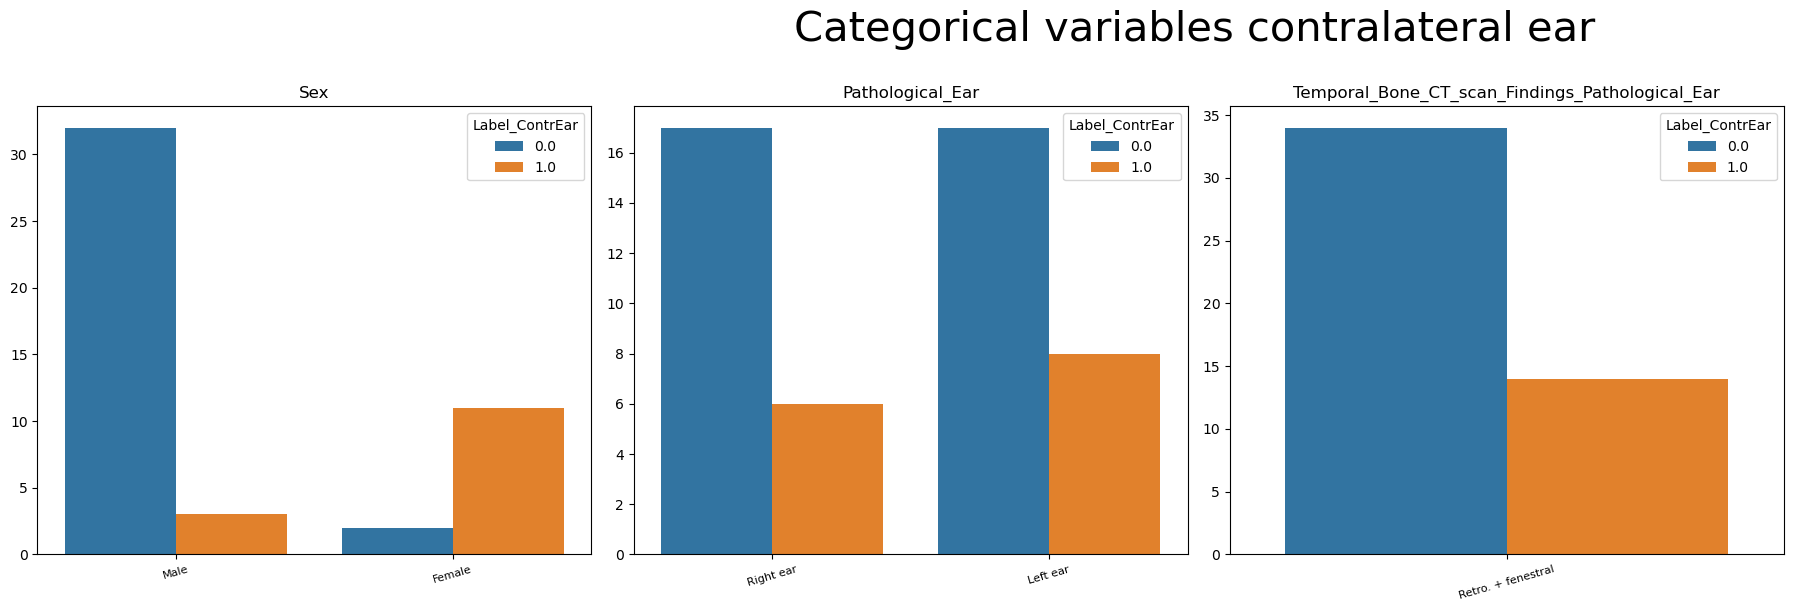

In [42]:
# Plotting Categorical variables - Bar plots
categories_contr_ear = [cat for cat in categories if cat in df_subset_ContraEar.columns]
categories_contr_ear.remove('Label_extended')
categories_contr_ear.remove('Label')

save_fig = 'Figures/3_2_6_bar_plots_categorical_vars_contr_ear'
categories_plotting (df=df_subset_ContraEar, plotting_vars=categories_contr_ear,    hue='Label_ContrEar', ncols=4,   figsize=(24,6),
                     title='Categorical variables contralateral ear',               show=True,            name=save_fig)